In [59]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from get_iEEG_data import *
from scipy.stats import wilcoxon
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SOZ_DIR = "../../Data/seizure_onset_zones/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
SEIZURE_BUFFER_TIME_MINUTES = 30  # minutes

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [160, 172, 141, 145, 138, 142, 151, 187]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())
# Initialize a dataframe with hup_id, dataset_name, fs
patients_df = pd.DataFrame(columns=["hup_id", "dataset_name", "fs"])
for patient_hup_id in completed_hup_ids:
    dataset_name = f"HUP{patient_hup_id}_phaseII"
    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    fs = int(dataset.get_time_series_details(channel_labels_to_download[0]).sample_rate)
    # Construct a row and add it to the dataframe
    row_df = pd.DataFrame(
        [{"hup_id": patient_hup_id, "dataset_name": dataset_name, "fs": fs}]
    )
    patients_df = pd.concat([patients_df, row_df], ignore_index=True)
# Sort the dataframe by hup_id
patients_df = patients_df.sort_values(by="hup_id")
# reset the index
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,dataset_name,fs
0,138,HUP138_phaseII,1024
1,141,HUP141_phaseII,512
2,142,HUP142_phaseII,512
3,145,HUP145_phaseII,512
4,151,HUP151_phaseII,512
5,160,HUP160_phaseII,1024
6,172,HUP172_phaseII,512
7,187,HUP187_phaseII,512


In [5]:
# def format_channels(channel_array):
#     formatted_array = []
#     for label in channel_array:
#         if label == "PZ":
#             formatted_array.append(label)
#             continue

#         # Splitting string into two parts: prefix (letters) and number
#         prefix, number = (
#             label[: -len([ch for ch in label if ch.isdigit()])],
#             label[-len([ch for ch in label if ch.isdigit()]) :],
#         )

#         # Formatting the number to have two digits
#         formatted_number = f"{int(number):02}"

#         # Appending prefix and formatted number
#         formatted_label = prefix + formatted_number
#         formatted_array.append(formatted_label)

#     return np.array(formatted_array)

In [6]:
all_spikes_dfs = []
all_fs = []

In [7]:
for index, row in patients_df.iterrows():
    patient_hup_id = row["hup_id"]
    fs = row["fs"]
    all_fs.append(fs)
    print(f"Processing HUP {patient_hup_id} with fs {fs}")

    ###############################
    # Construct spike_files_df
    ###############################

    # Initialize an empty list to hold the data
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(SPIKES_OUTPUT_DIR):
        # Check if the file ends with .npy
        if filename.endswith(".npy"):
            # Use regular expression to match the pattern and extract desired numbers
            match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

            if match:
                current_patient_hup_id = int(match.group(1))
                if current_patient_hup_id != patient_hup_id:
                    continue
                interval_index = int(match.group(2))

                # Append the data to the list
                data.append(
                    {
                        "filename": filename,
                        "interval_index": interval_index,
                    }
                )

    # Convert the list of dictionaries to a pandas DataFrame
    spike_files_df = pd.DataFrame(data)
    # Sort the DataFrame by the interval index
    spike_files_df = spike_files_df.sort_values(by="interval_index")
    # Reset the index
    spike_files_df = spike_files_df.reset_index(drop=True)
    # Add a new column called "start_sample_index"
    spike_files_df["start_sample_index"] = (
        spike_files_df["interval_index"] * fs * 60 * 2
    )

    ###############################
    # Construct all_spikes_df
    ###############################
    # Initialize an empty list to store individual DataFrames
    dfs = []

    for index, row in spike_files_df.iterrows():
        filename = row["filename"]
        start_sample_index = row["start_sample_index"]

        # Load the data
        spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

        # Adjust the start_sample_index
        spike_data[:, 0] += start_sample_index

        # Convert the modified spike_data to a DataFrame and append to the dfs list
        dfs.append(
            pd.DataFrame(
                spike_data,
                columns=[
                    "peak_index",
                    "channel_index",
                    "peak",
                    "left_point",
                    "right_point",
                    "slow_end",
                    "slow_max",
                    "rise_amp",
                    "decay_amp",
                    "slow_width",
                    "slow_amp",
                    "rise_slope",
                    "decay_slope",
                    "average_amp",
                    "linelen",
                ],
            )
        )

    # Concatenate all the individual DataFrames into a single DataFrame
    all_spikes_df = pd.concat(dfs, ignore_index=True)
    # Drop any rows with any NaN values
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)
    # Make peak_index and channel_index integers
    all_spikes_df["peak_index"] = all_spikes_df["peak_index"].astype(int)
    print((all_spikes_df["peak_index"] / fs / 3600).max())
    all_spikes_df["channel_index"] = all_spikes_df["channel_index"].astype(int)

    ###############################
    # ISI
    ###############################
    # Calculate the inter-spike interval
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

    # Drop the first row and reset index
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)

    # Convert the inter_spike_interval_samples column to integer
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
        "inter_spike_interval_samples"
    ].astype(int)

    all_spikes_df["inter_spike_interval_sec"] = (
        all_spikes_df["inter_spike_interval_samples"] / fs
    ).astype(int)

    all_spikes_dfs.append(all_spikes_df)

Processing HUP 138 with fs 1024
171.85119411892362
Processing HUP 141 with fs 512
146.330791015625
Processing HUP 142 with fs 512
310.79945583767363
Processing HUP 145 with fs 512
260.2655815972222
Processing HUP 151 with fs 512
187.29906955295138
Processing HUP 160 with fs 1024
272.4980699327257
Processing HUP 172 with fs 512
239.691240234375
Processing HUP 187 with fs 512
173.76210340711805


## Interspike Interval Distribution

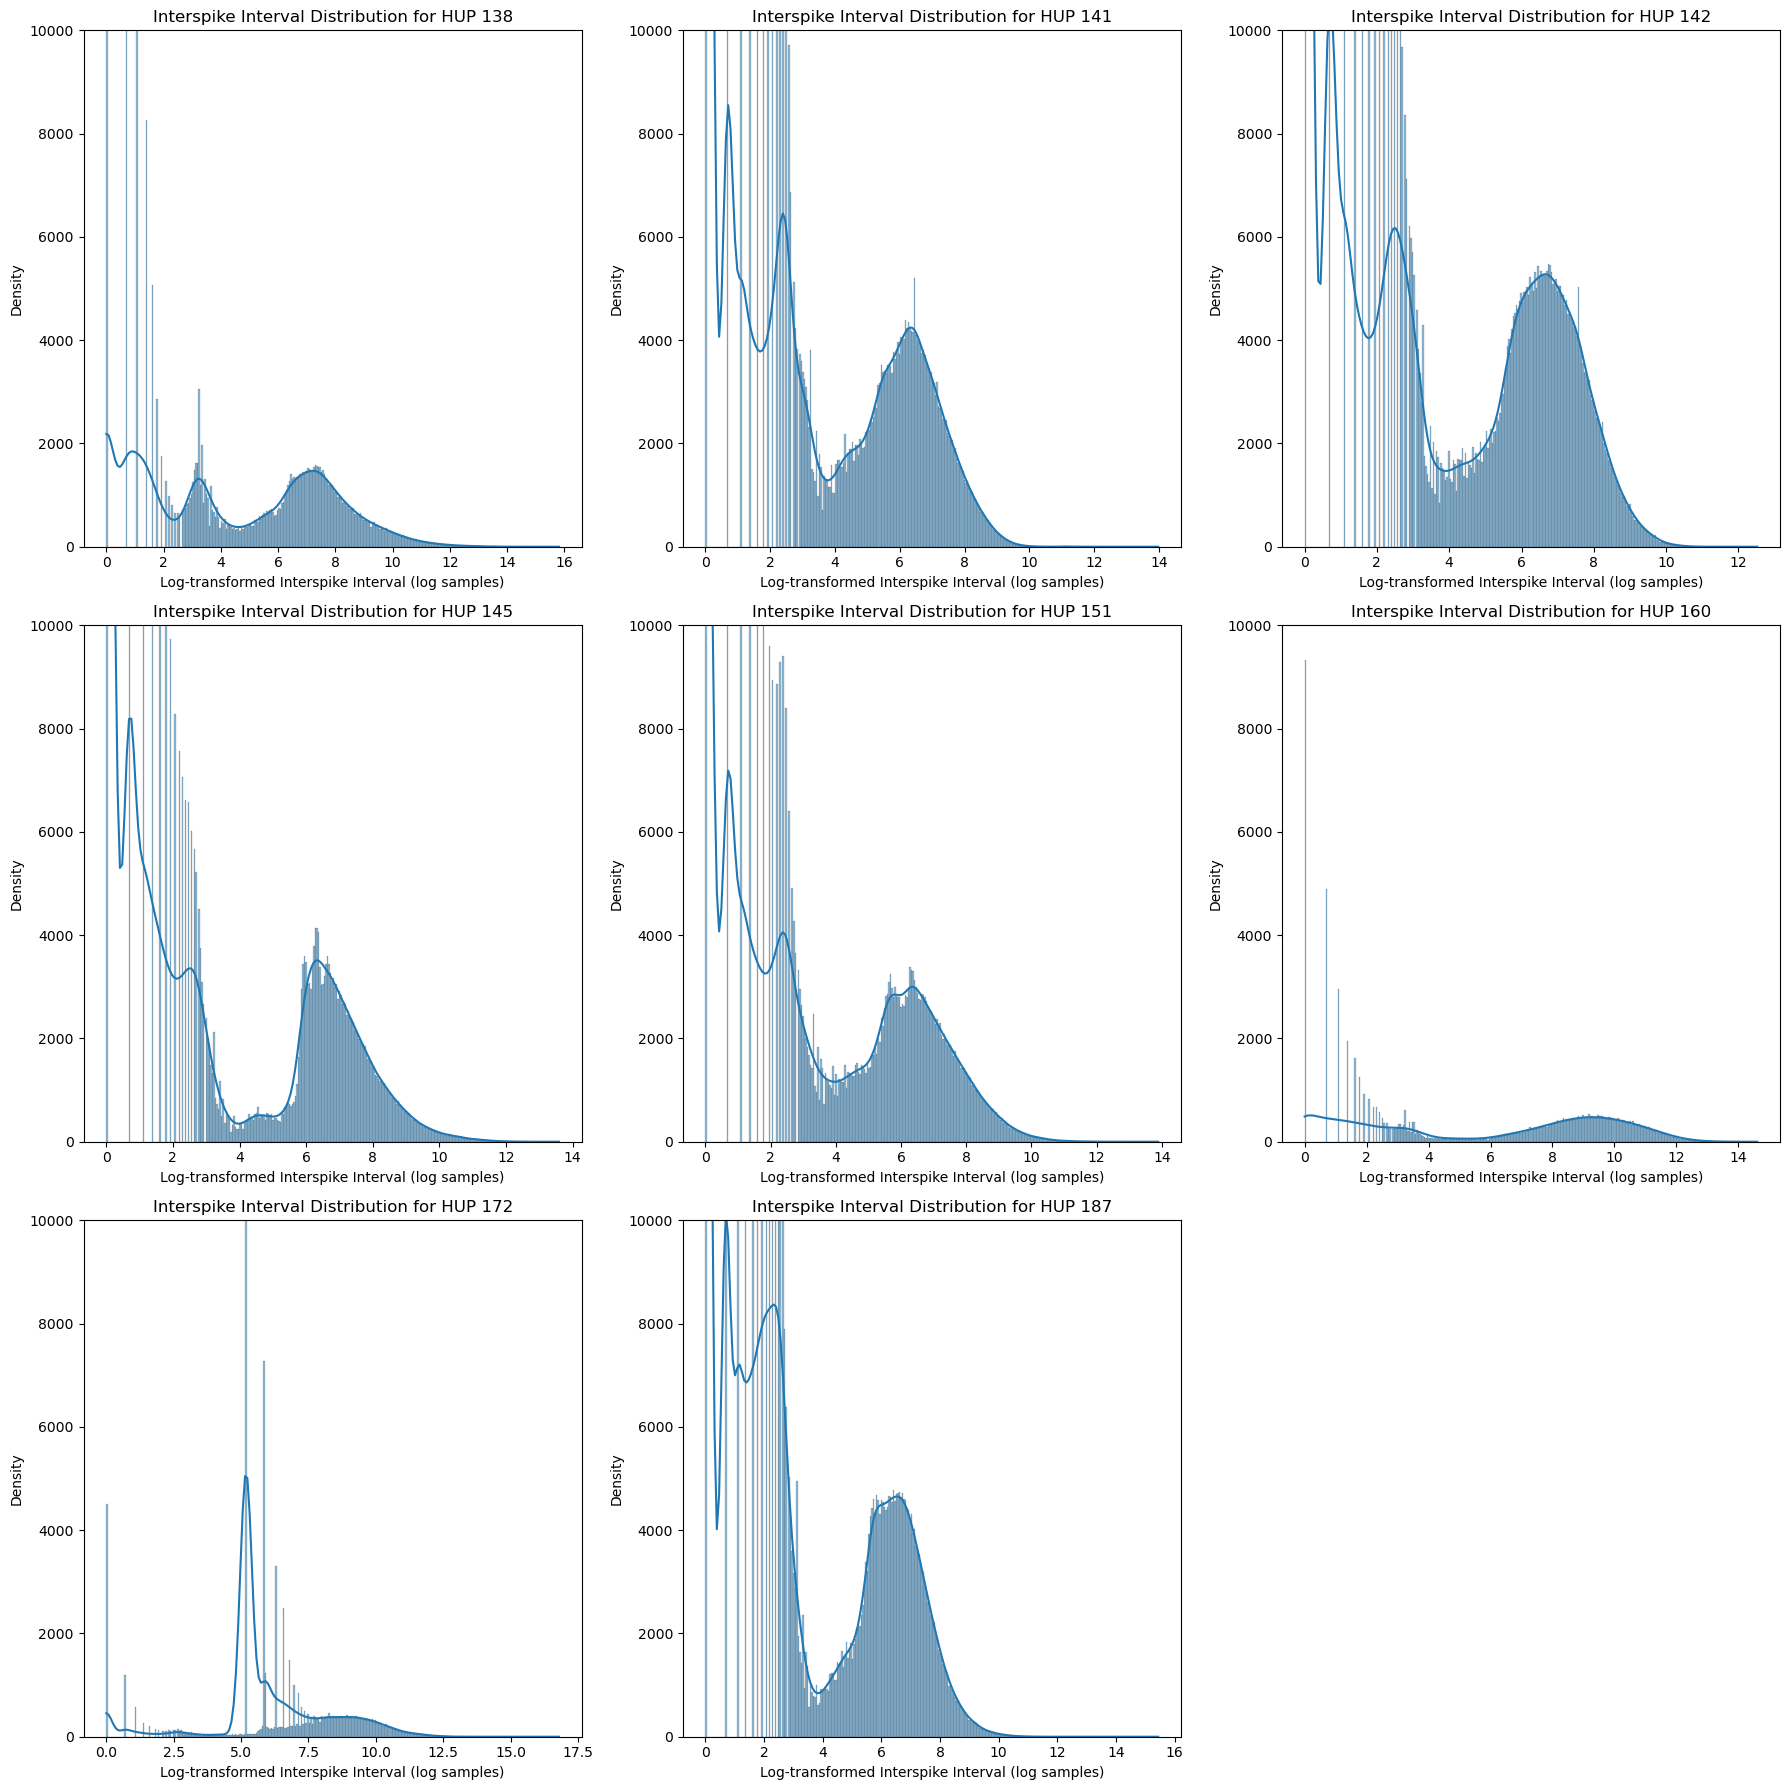

In [8]:
# Determine number of rows
num_plots = len(completed_hup_ids)
num_columns = 3
num_rows = (num_plots + 2) // num_columns  # ceil division

# Create a main figure and axes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

# If there's only one row, axes is 1D and we should reshape it
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (hup_id, all_spikes_df) in enumerate(zip(completed_hup_ids, all_spikes_dfs)):
    # Find the row in patients_df that corresponds to the current hup_id
    patient_row = patients_df[patients_df["hup_id"] == hup_id]

    # Visualize with log transformation (excluding zeros to avoid -inf)
    log_data = np.log(
        all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
            "inter_spike_interval_samples"
        ]
    )

    ax = axes[idx // num_columns, idx % num_columns]
    sns.histplot(log_data, kde=True, bins=300, ax=ax)
    ax.set_title(f"Interspike Interval Distribution for HUP {hup_id}")
    ax.set_xlabel("Log-transformed Interspike Interval (log samples)")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 10000)

# Remove any unused subplots
for idx in range(num_plots, num_rows * num_columns):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

## Interspike Interval Change over time

In [9]:
for all_spikes_df, fs, hup_id in zip(all_spikes_dfs, all_fs, completed_hup_ids):
    print(f"HUP {hup_id} with fs {fs}")
    # Convert peak_index to second
    all_spikes_df["peak_second"] = all_spikes_df["peak_index"] // fs
    # Convert peak_index to minute
    all_spikes_df["peak_minute"] = all_spikes_df["peak_index"] / fs // 60
    # Convert peak_index to hour
    all_spikes_df["peak_hour"] = all_spikes_df["peak_index"] / fs // 3600

HUP 138 with fs 1024
HUP 141 with fs 512
HUP 142 with fs 512


HUP 145 with fs 512
HUP 151 with fs 512
HUP 160 with fs 1024
HUP 172 with fs 512
HUP 187 with fs 512


- there seems to be a dichotomy between 50 samples regardless of sampling rate. Why regardless of sampling rate???
- less than 50 samples of delay could mean they're distrinct spikes.
- while greater than that might be propogation?
- or the other way around?

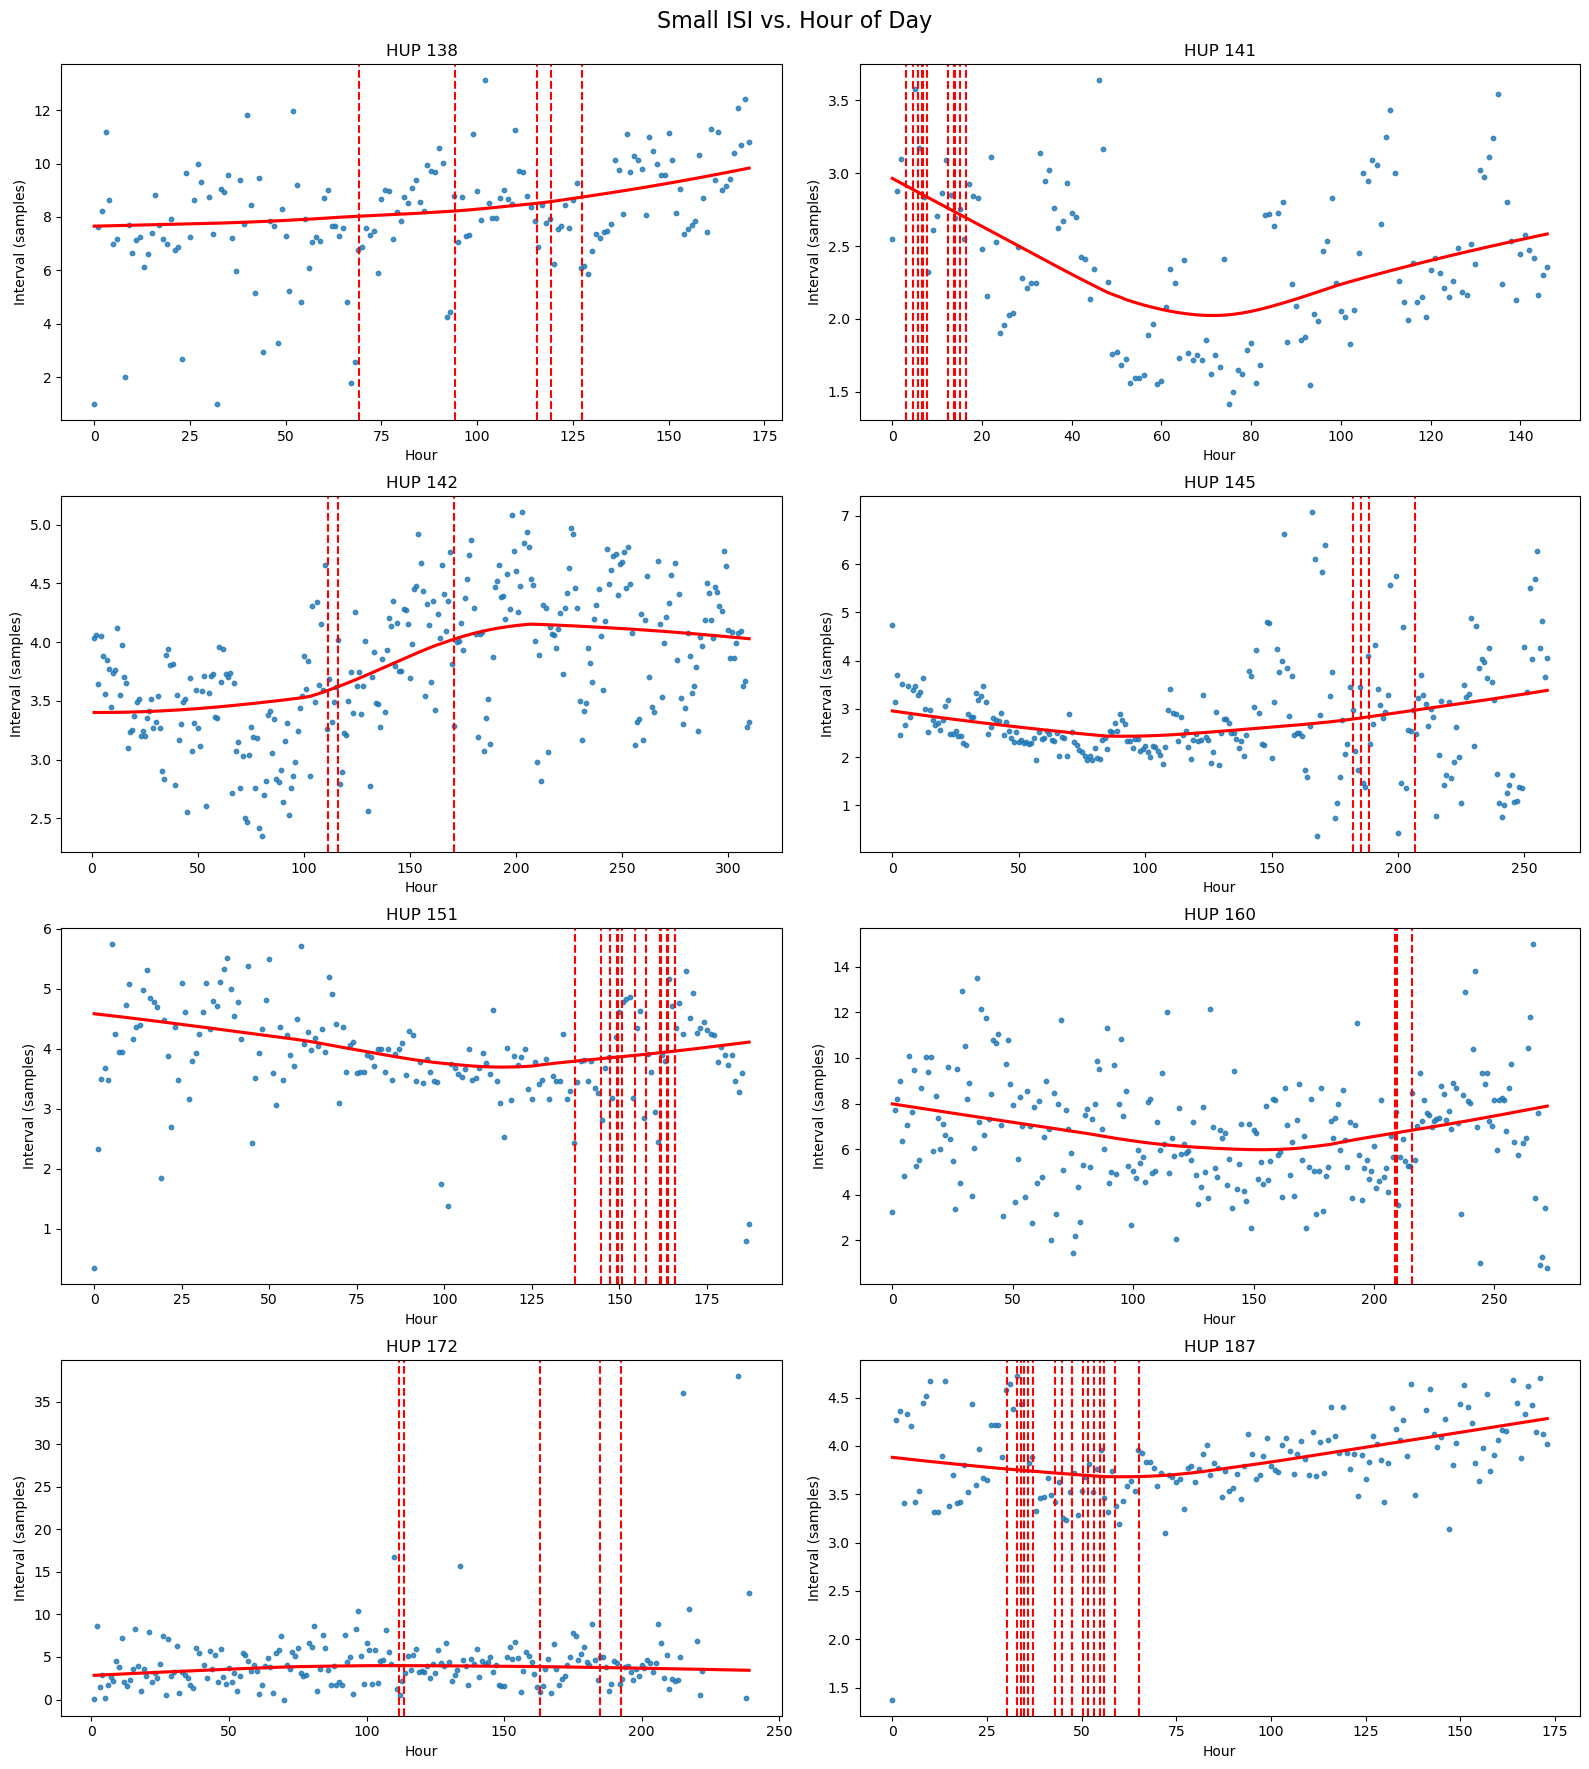

In [10]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

# Looping over the dataframes
for all_spikes_df, fs, hup_id in zip(all_spikes_dfs, all_fs, completed_hup_ids):
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < 55]

    # Group by peak_hour and take the mean
    grouped = filtered_df.groupby("peak_hour").mean()
    # Find the indices of the two largest inter_spike_interval_samples
    indices_to_drop = grouped["inter_spike_interval_samples"].nlargest(2).index
    # Drop those rows
    grouped.drop(indices_to_drop, inplace=True)

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting using seaborn's regplot
    sns.regplot(
        x=grouped.index,
        y=grouped["inter_spike_interval_samples"],
        ax=axarr[row, col],
        lowess=True,
        scatter_kws={"s": 10},
        line_kws={"color": "red"},
    )

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours
    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Interval (samples)")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Small ISI vs. Hour of Day", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

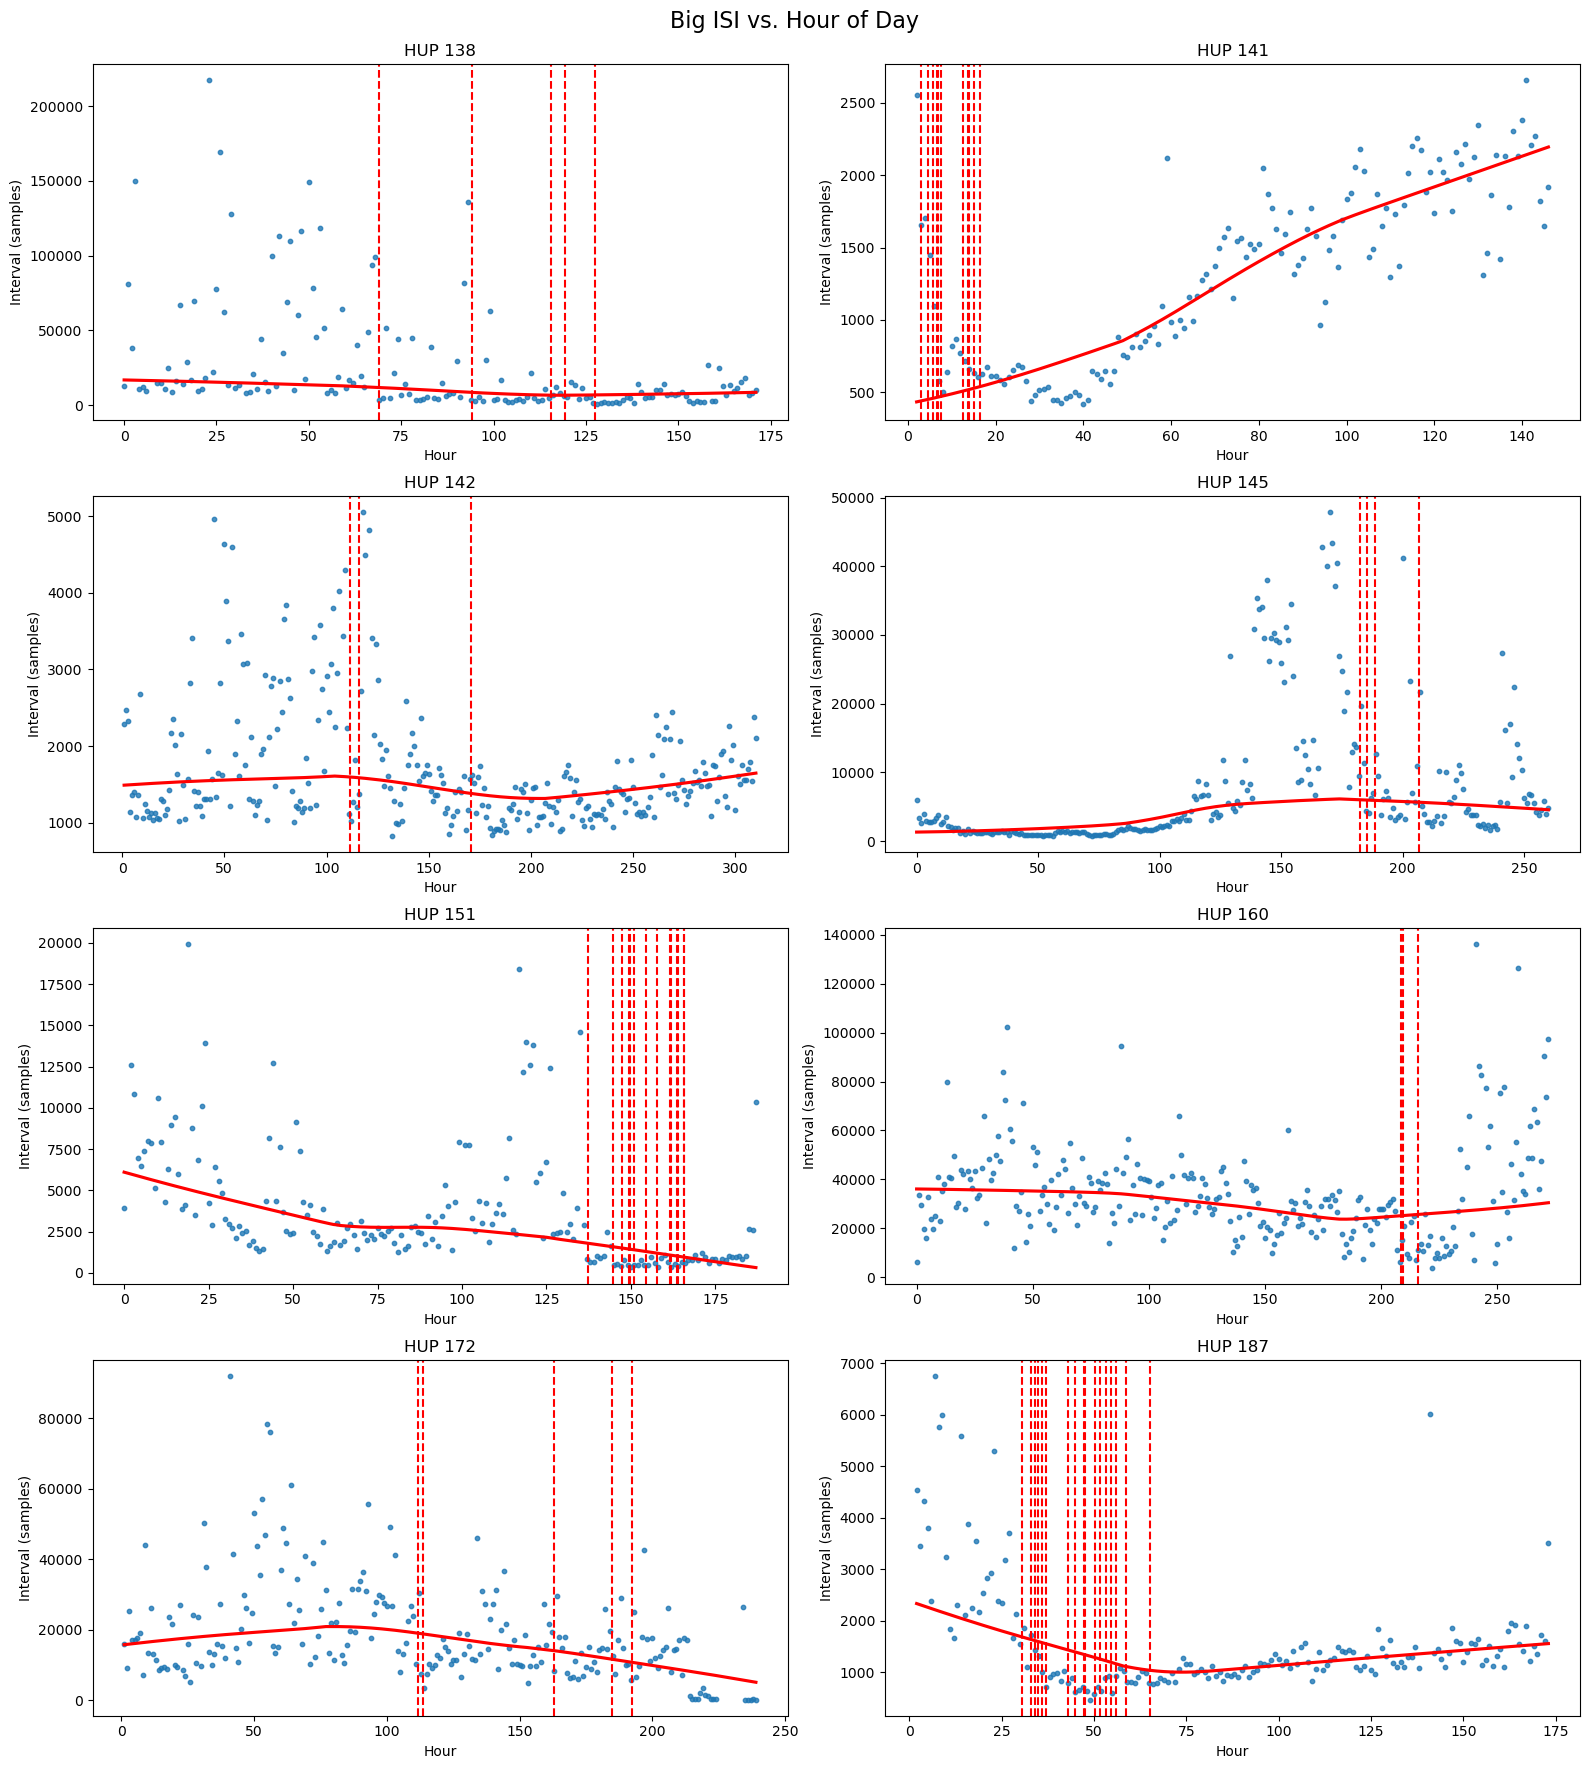

In [13]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

# Looping over the dataframes
for all_spikes_df, fs, hup_id in zip(all_spikes_dfs, all_fs, completed_hup_ids):
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples > 55]

    # Group by peak_hour and take the mean
    grouped = filtered_df.groupby("peak_hour").mean()
    # Find the indices of the two largest inter_spike_interval_samples
    indices_to_drop = grouped["inter_spike_interval_samples"].nlargest(2).index
    # Drop those rows
    grouped.drop(indices_to_drop, inplace=True)

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting using seaborn's regplot
    sns.regplot(
        x=grouped.index,
        y=grouped["inter_spike_interval_samples"],
        ax=axarr[row, col],
        lowess=True,
        scatter_kws={"s": 10},
        line_kws={"color": "red"},
    )

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours
    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Interval (samples)")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
fig.suptitle("Big ISI vs. Hour of Day", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

## Heterogenity and variations of ISI and how it changes over time

Processing HUP 138...
[166.0, 167.0, 168.0]
21.02356544455456 17.050261801861684 18.015257882149463
Processing HUP 141...


[141.0, 142.0, 143.0]
11.60613317483814 13.771325492488293 12.982738021602286
Processing HUP 142...
[305.0, 306.0, 307.0]
14.57584445926977 14.57584445926977 15.960247829676762
Processing HUP 145...
[254.0, 255.0, 256.0]
14.35274047985897 12.270092642339838 18.10911339130046
Processing HUP 151...
[182.0, 183.0, 184.0]
15.144579998073372 14.855401594856637 14.666082869762352
Processing HUP 160...
[267.0, 268.0, 269.0]
21.943835054204538 16.05568836809472 24.725344644750788
Processing HUP 172...
[221.0, 222.0, 223.0]
19.901819744883586 16.168202097456433 26.593214483139864
Processing HUP 187...
[168.0, 169.0, 170.0]
9.047516580176989 12.488565923567505 13.395571133743044


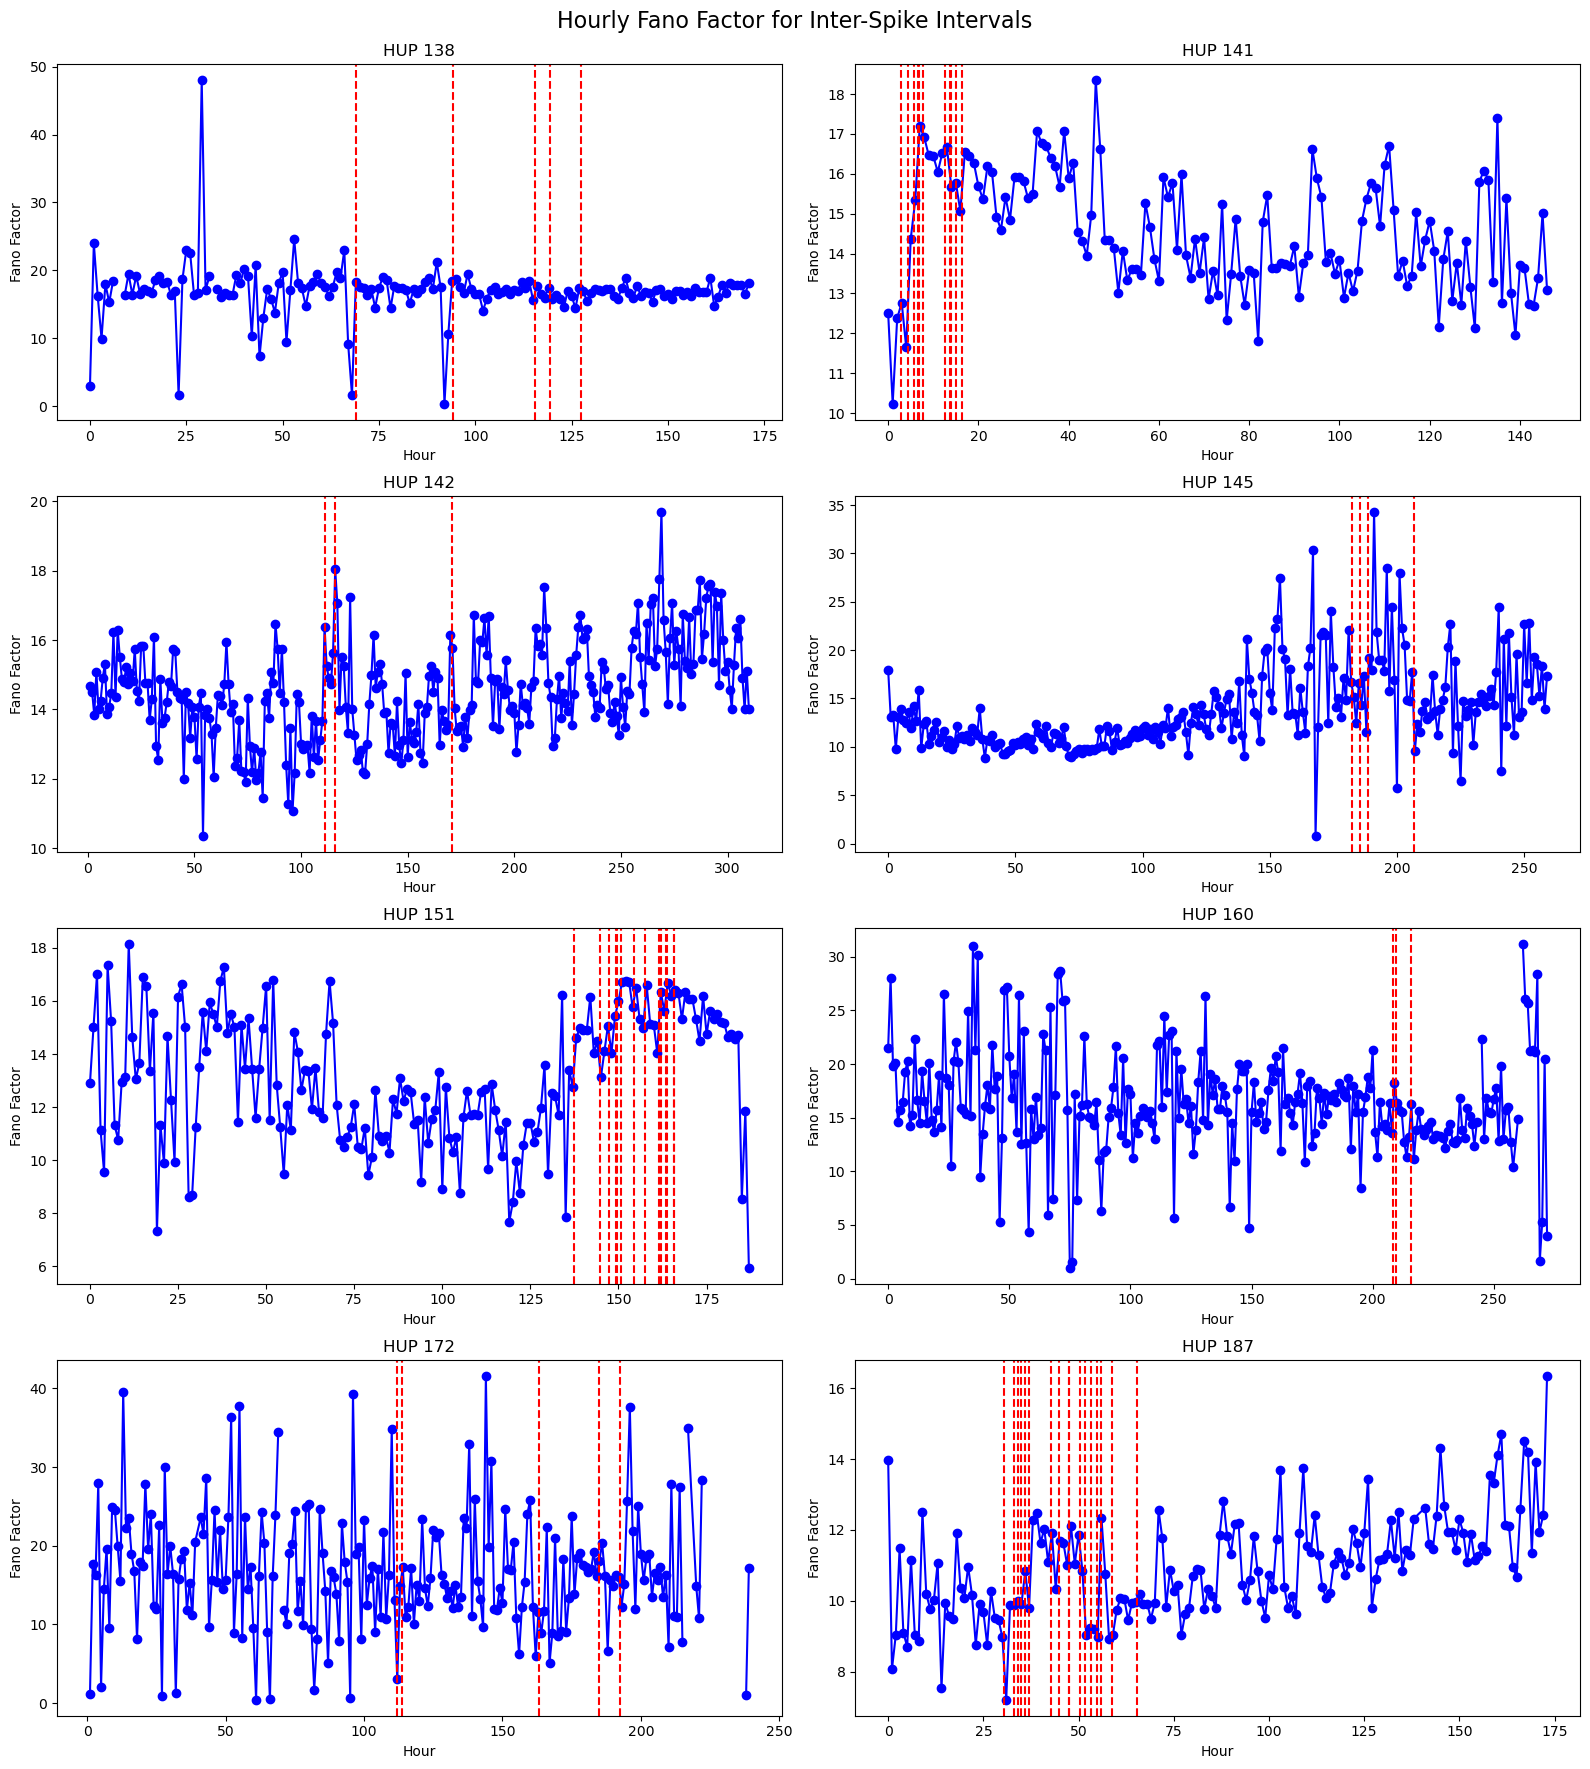

In [55]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

max_medication_fanos = []
before_seizure_fanos = []
after_seizure_fanos = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id in zip(all_spikes_dfs, all_fs, completed_hup_ids):
    print(f"Processing HUP {hup_id}...")
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < 55]

    # Extracting Fano Factors for the three scenarios:

    # 1. Max medication
    max_medication_data = filtered_df[filtered_df["peak_hour"].isin([0, 1, 2])][
        "inter_spike_interval_samples"
    ]
    max_medication_fano = max_medication_data.var() / max_medication_data.mean()
    max_medication_fanos.append(max_medication_fano)

    # 2. Before seizure
    first_seizure_hour = int(seizure_times_hour[0])
    before_seizure_data = filtered_df[
        filtered_df["peak_hour"].isin(
            range(first_seizure_hour - 2, first_seizure_hour + 1)
        )
    ]["inter_spike_interval_samples"]
    before_seizure_fano = before_seizure_data.var() / before_seizure_data.mean()
    before_seizure_fanos.append(before_seizure_fano)

    # 3. After seizure
    last_hours = sorted(filtered_df["peak_hour"].unique())[-6:-3]
    print(last_hours)
    after_seizure_data = filtered_df[filtered_df["peak_hour"].isin(last_hours)][
        "inter_spike_interval_samples"
    ]
    after_seizure_fano = after_seizure_data.var() / after_seizure_data.mean()
    after_seizure_fanos.append(after_seizure_fano)

    print(max_medication_fano, before_seizure_fano, after_seizure_fano)

    # Compute mean and variance by peak_hour
    grouped_mean = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].mean()
    grouped_variance = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].var()

    # Compute Fano Factor for each hour
    fano_factors = grouped_variance / grouped_mean

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting the Fano Factor
    axarr[row, col].plot(fano_factors.index, fano_factors, "-o", color="blue")

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours
    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Fano Factor")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Hourly Fano Factor for Inter-Spike Intervals", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

In [56]:
# # Creating a subplot figure
# n_patients = len(all_spikes_dfs)
# fig, axarr = plt.subplots(
#     nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
# )

# # Looping over the dataframes
# for all_spikes_df, fs, hup_id in zip(all_spikes_dfs, all_fs, completed_hup_ids):
#     # Filtering the rows
#     filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < 55]

#     # Compute mean and variance by peak_hour
#     grouped_mean = filtered_df.groupby("peak_hour")[
#         "inter_spike_interval_samples"
#     ].mean()
#     grouped_variance = filtered_df.groupby("peak_hour")[
#         "inter_spike_interval_samples"
#     ].var()

#     # Compute Fano Factor for each hour
#     fano_factors = grouped_variance / grouped_mean

#     # Get the subplot index
#     idx = completed_hup_ids.index(hup_id)
#     row = idx // 2
#     col = idx % 2

#     # Plotting using seaborn's regplot
#     sns.regplot(
#         x=fano_factors.index,
#         y=fano_factors,
#         ax=axarr[row, col],
#         lowess=True,
#         scatter_kws={"s": 10},
#         line_kws={"color": "red"},
#     )

#     # Load seizure times and plot vertical lines
#     seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
#     seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours
#     for seizure_time in seizure_times_hour:
#         axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

#     axarr[row, col].set_title(f"HUP {hup_id}")
#     axarr[row, col].set_xlabel("Hour")
#     axarr[row, col].set_ylabel("Fano Factor")

# # Delete unused subplots
# for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
#     row = i // 2
#     col = i % 2
#     fig.delaxes(axarr[row, col])

# plt.tight_layout()
# # Add a title
# fig.suptitle("Hourly Fano Factor for Inter-Spike Intervals", fontsize=16)
# plt.subplots_adjust(top=0.95)
# plt.show()

In [57]:
max_medication_fanos, before_seizure_fanos, after_seizure_fanos

([21.02356544455456,
  11.60613317483814,
  14.57584445926977,
  14.35274047985897,
  15.144579998073372,
  21.943835054204538,
  19.901819744883586,
  9.047516580176989],
 [17.050261801861684,
  13.771325492488293,
  14.57584445926977,
  12.270092642339838,
  14.855401594856637,
  16.05568836809472,
  16.168202097456433,
  12.488565923567505],
 [18.015257882149463,
  12.982738021602286,
  15.960247829676762,
  18.10911339130046,
  14.666082869762352,
  24.725344644750788,
  26.593214483139864,
  13.395571133743044])

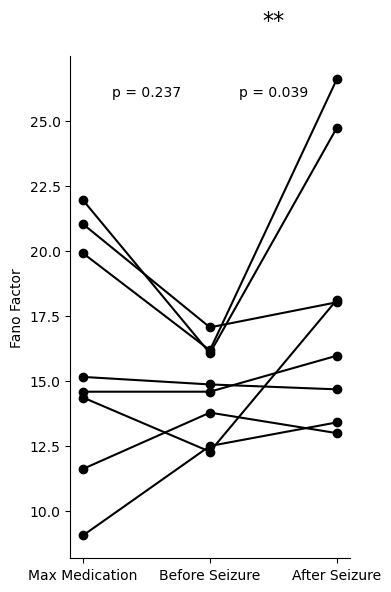

In [69]:
# 2. Visualize the data
plt.figure(figsize=(4, 6))

for i in range(n_patients):
    plt.plot(
        [0, 1, 2],
        [max_medication_fanos[i], before_seizure_fanos[i], after_seizure_fanos[i]],
        marker="o",
        color="black",
    )

plt.xticks([0, 1, 2], ["Max Medication", "Before Seizure", "After Seizure"])
plt.ylabel("Fano Factor")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 3. Run statistical tests
w1, p1 = wilcoxon(max_medication_fanos, before_seizure_fanos)
w2, p2 = wilcoxon(before_seizure_fanos, after_seizure_fanos)

# Add p-values to the plot
significance_marker = "**"  # using a star as the significance marker
alpha = 0.05  # typical threshold for significance

if p1 < alpha:
    plt.text(
        0.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    0.5,
    0.95 * plt.ylim()[1],
    f"p = {p1:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

if p2 < alpha:
    plt.text(
        1.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    1.5,
    0.95 * plt.ylim()[1],
    f"p = {p2:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

## Morphologies

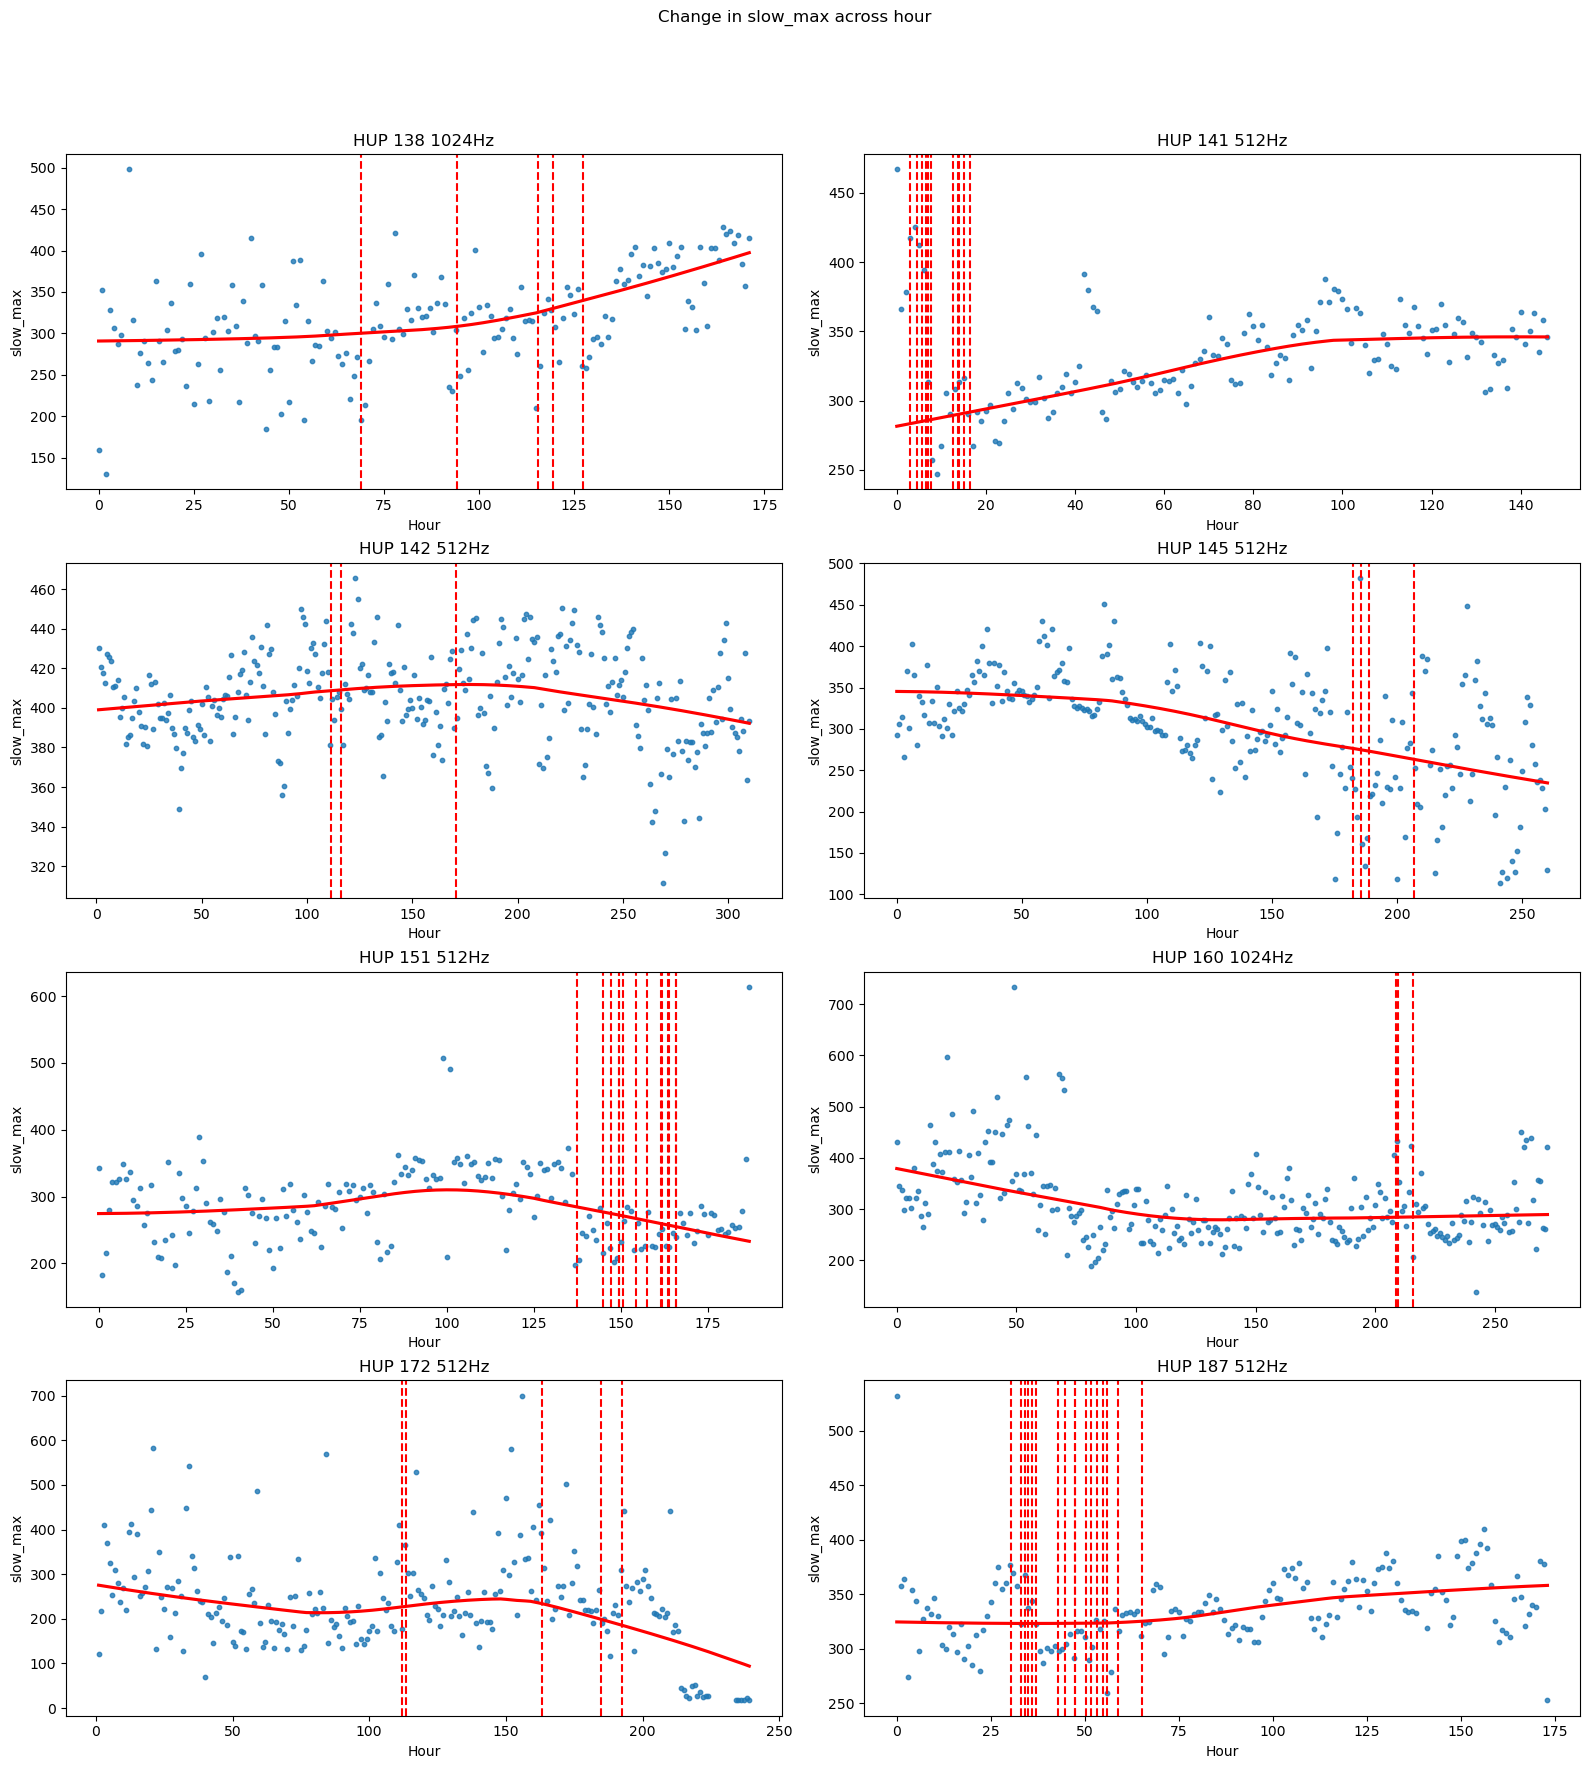

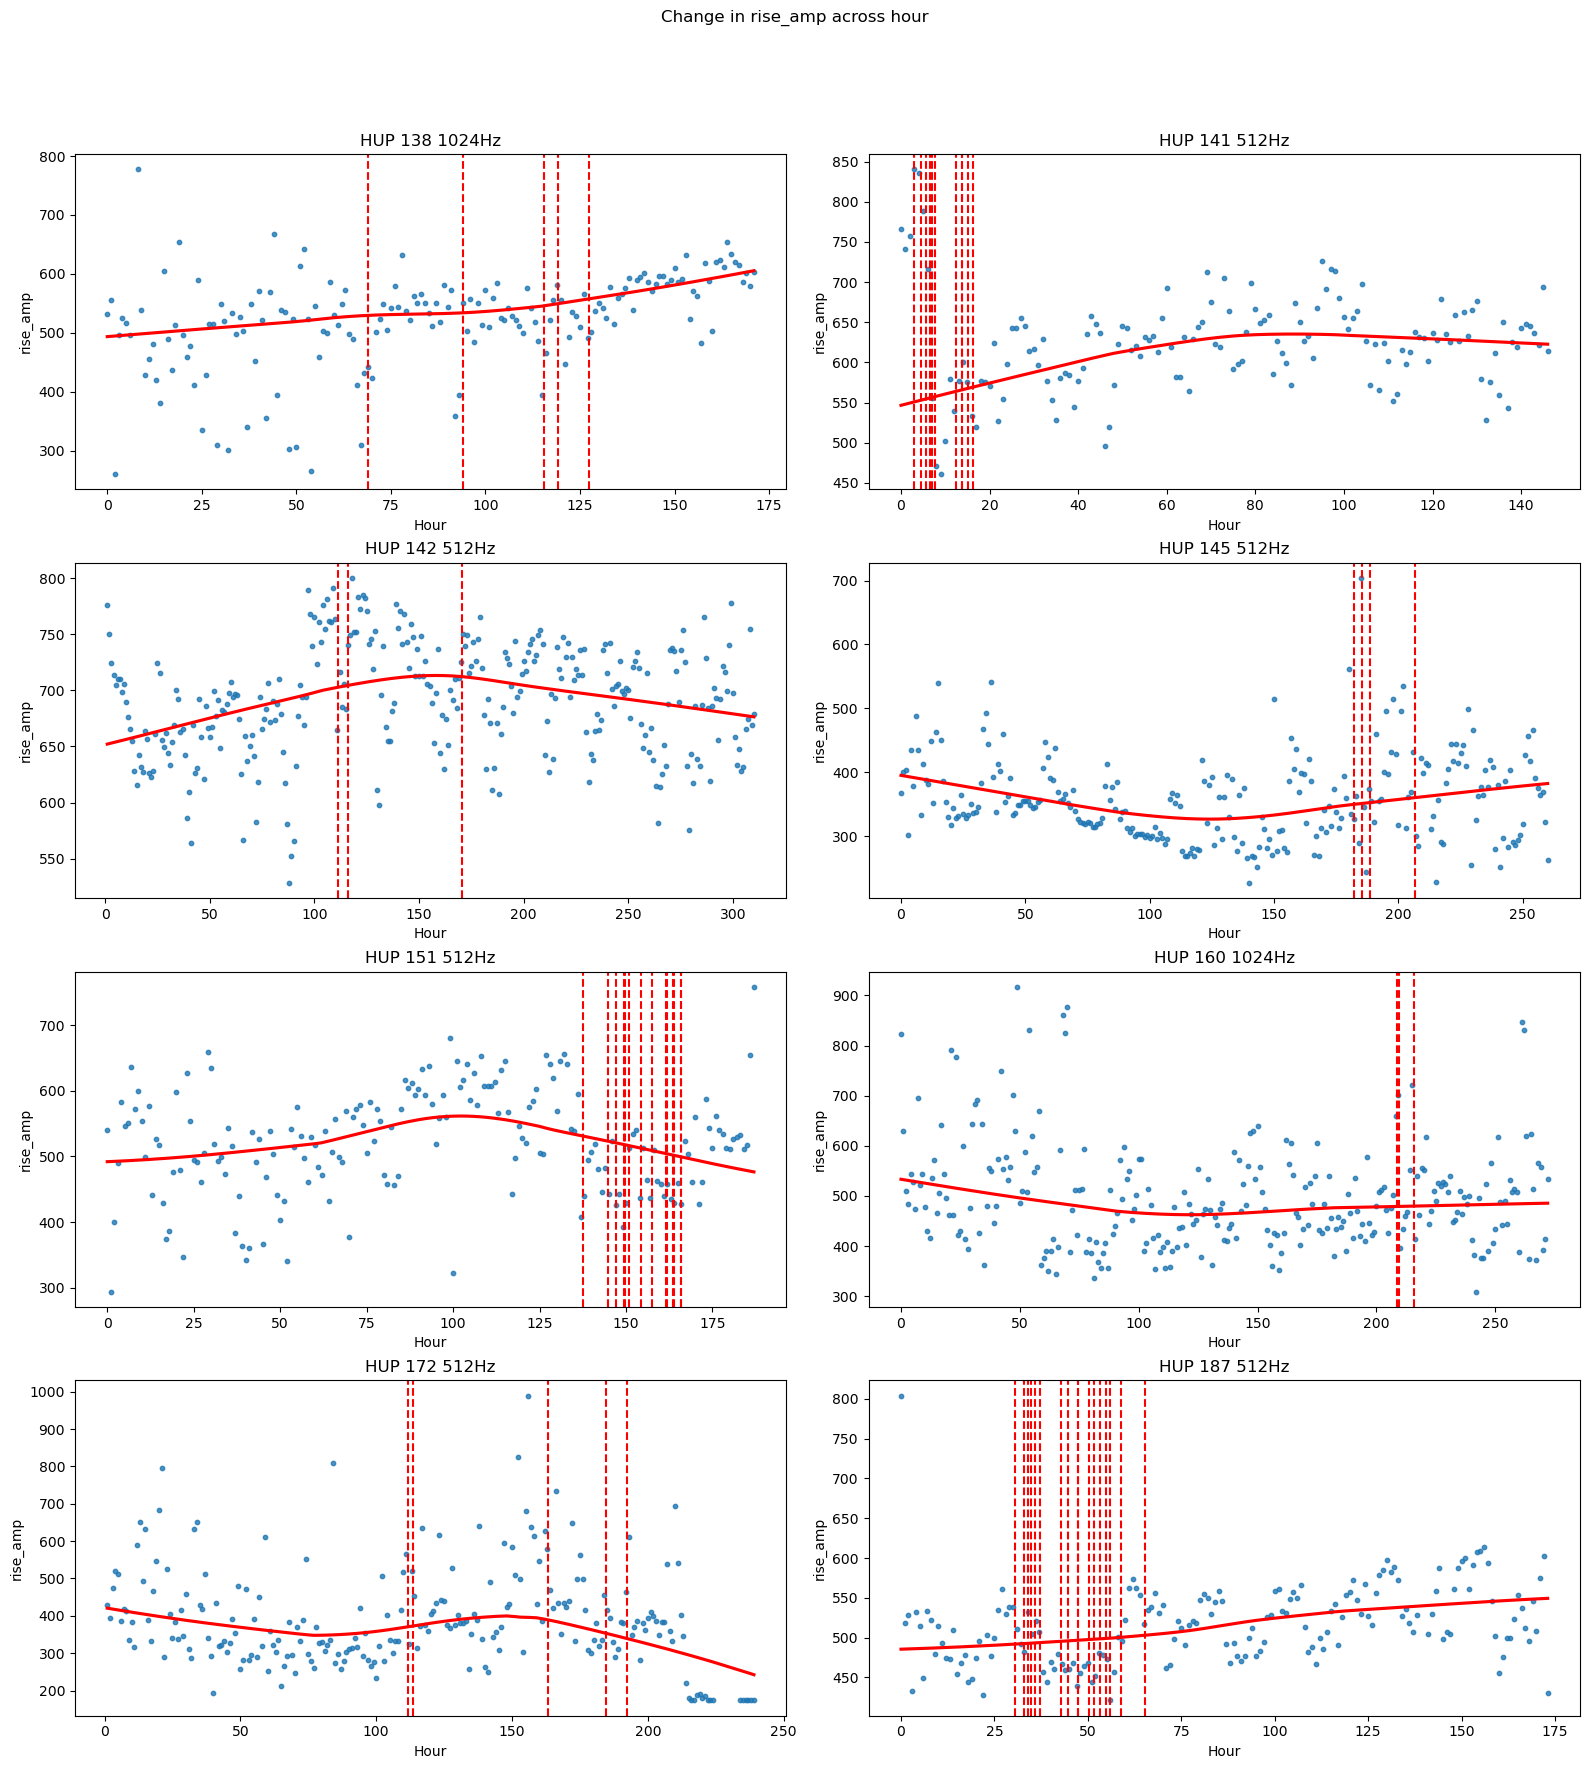

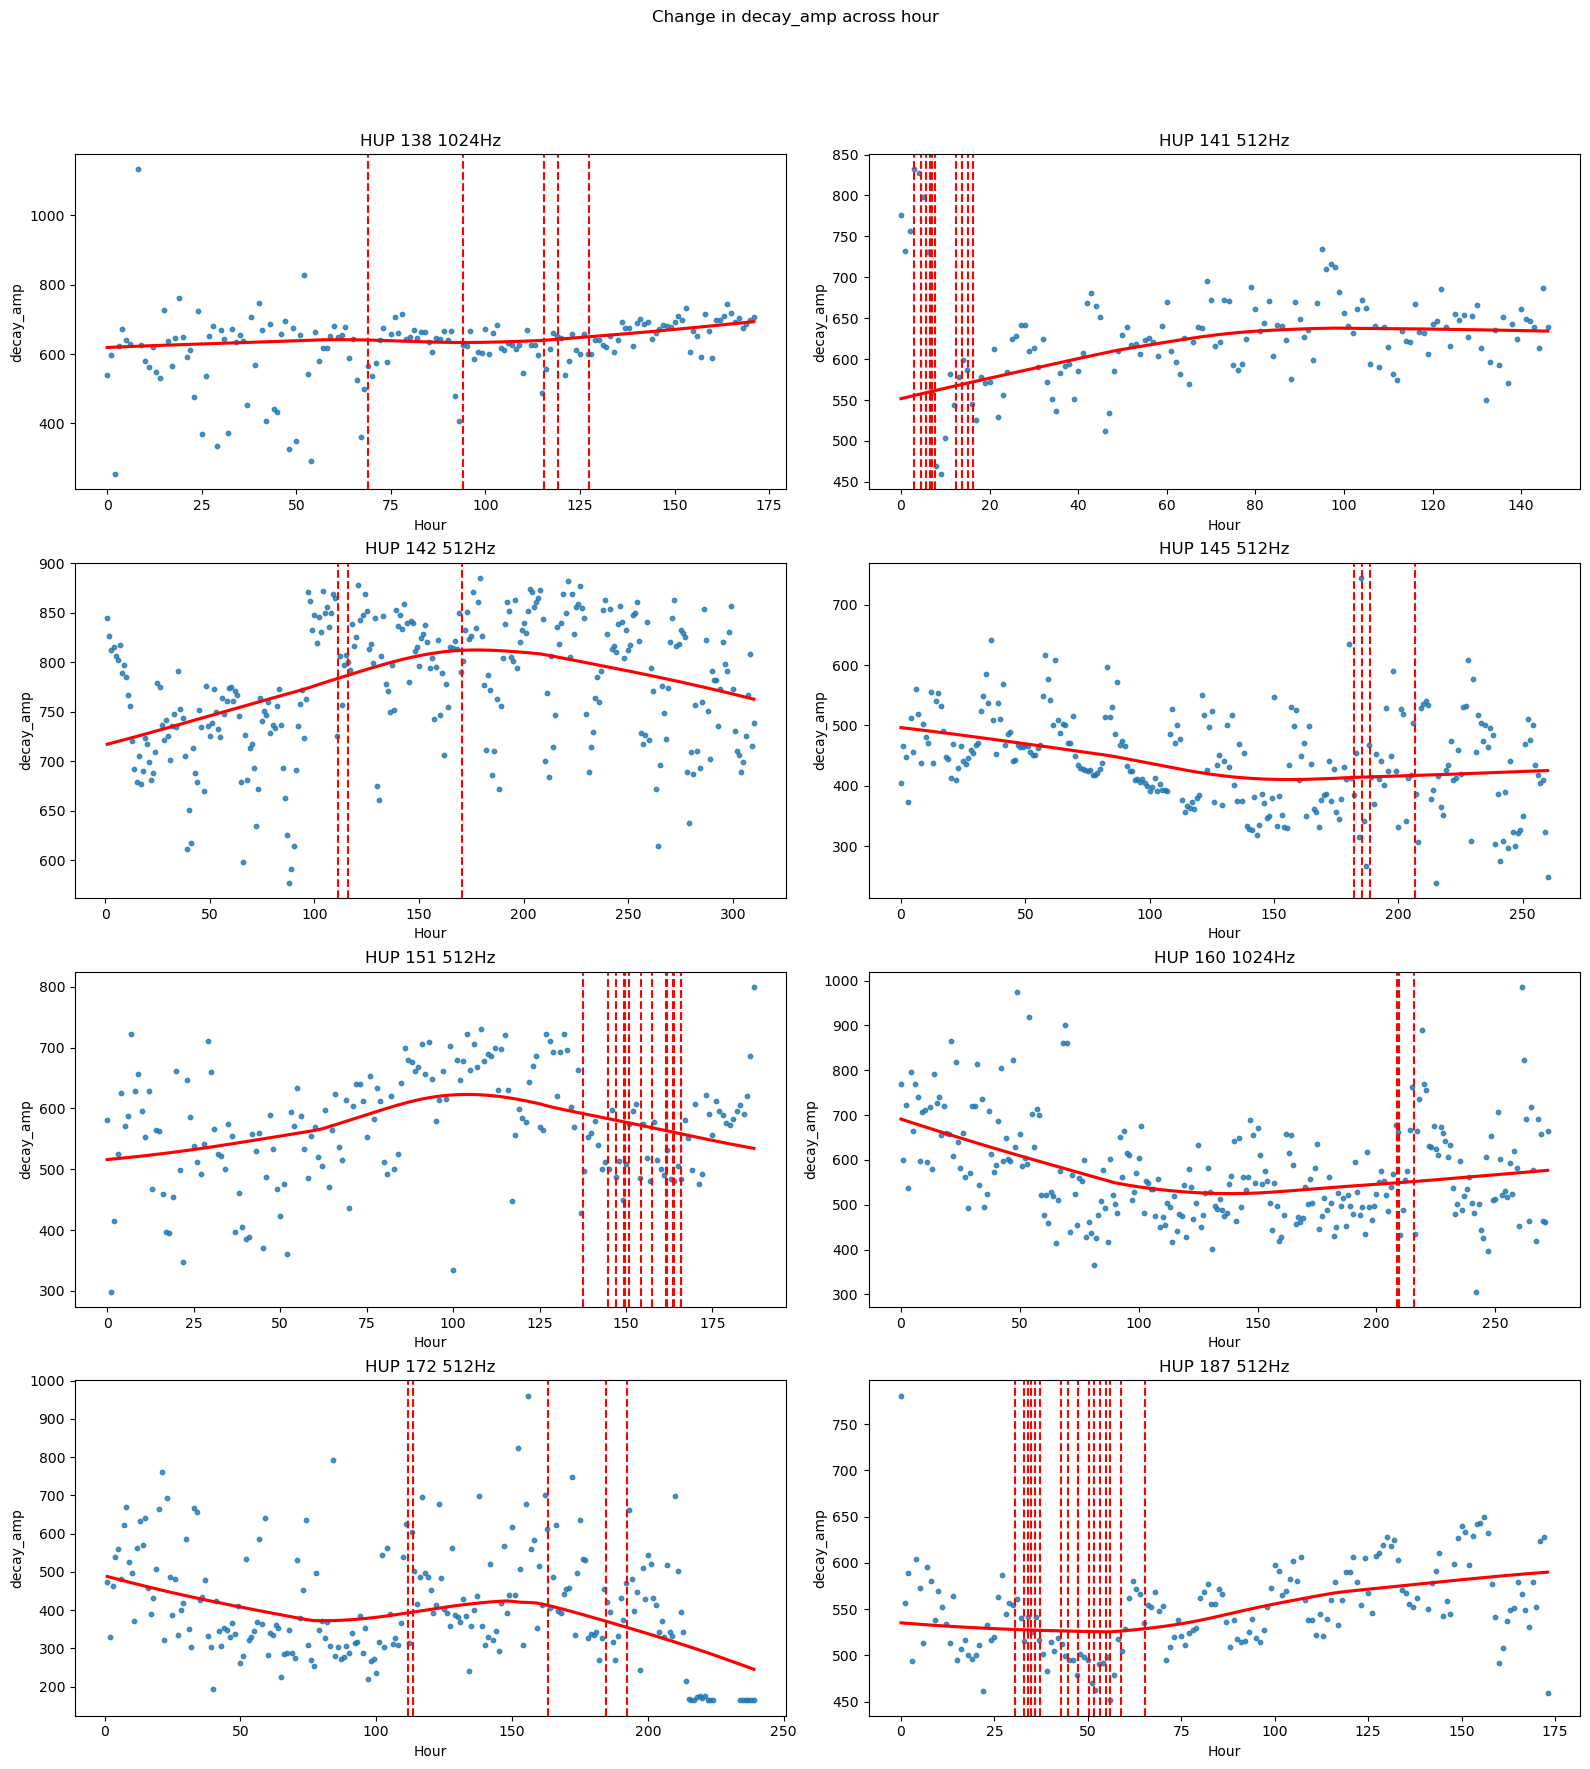

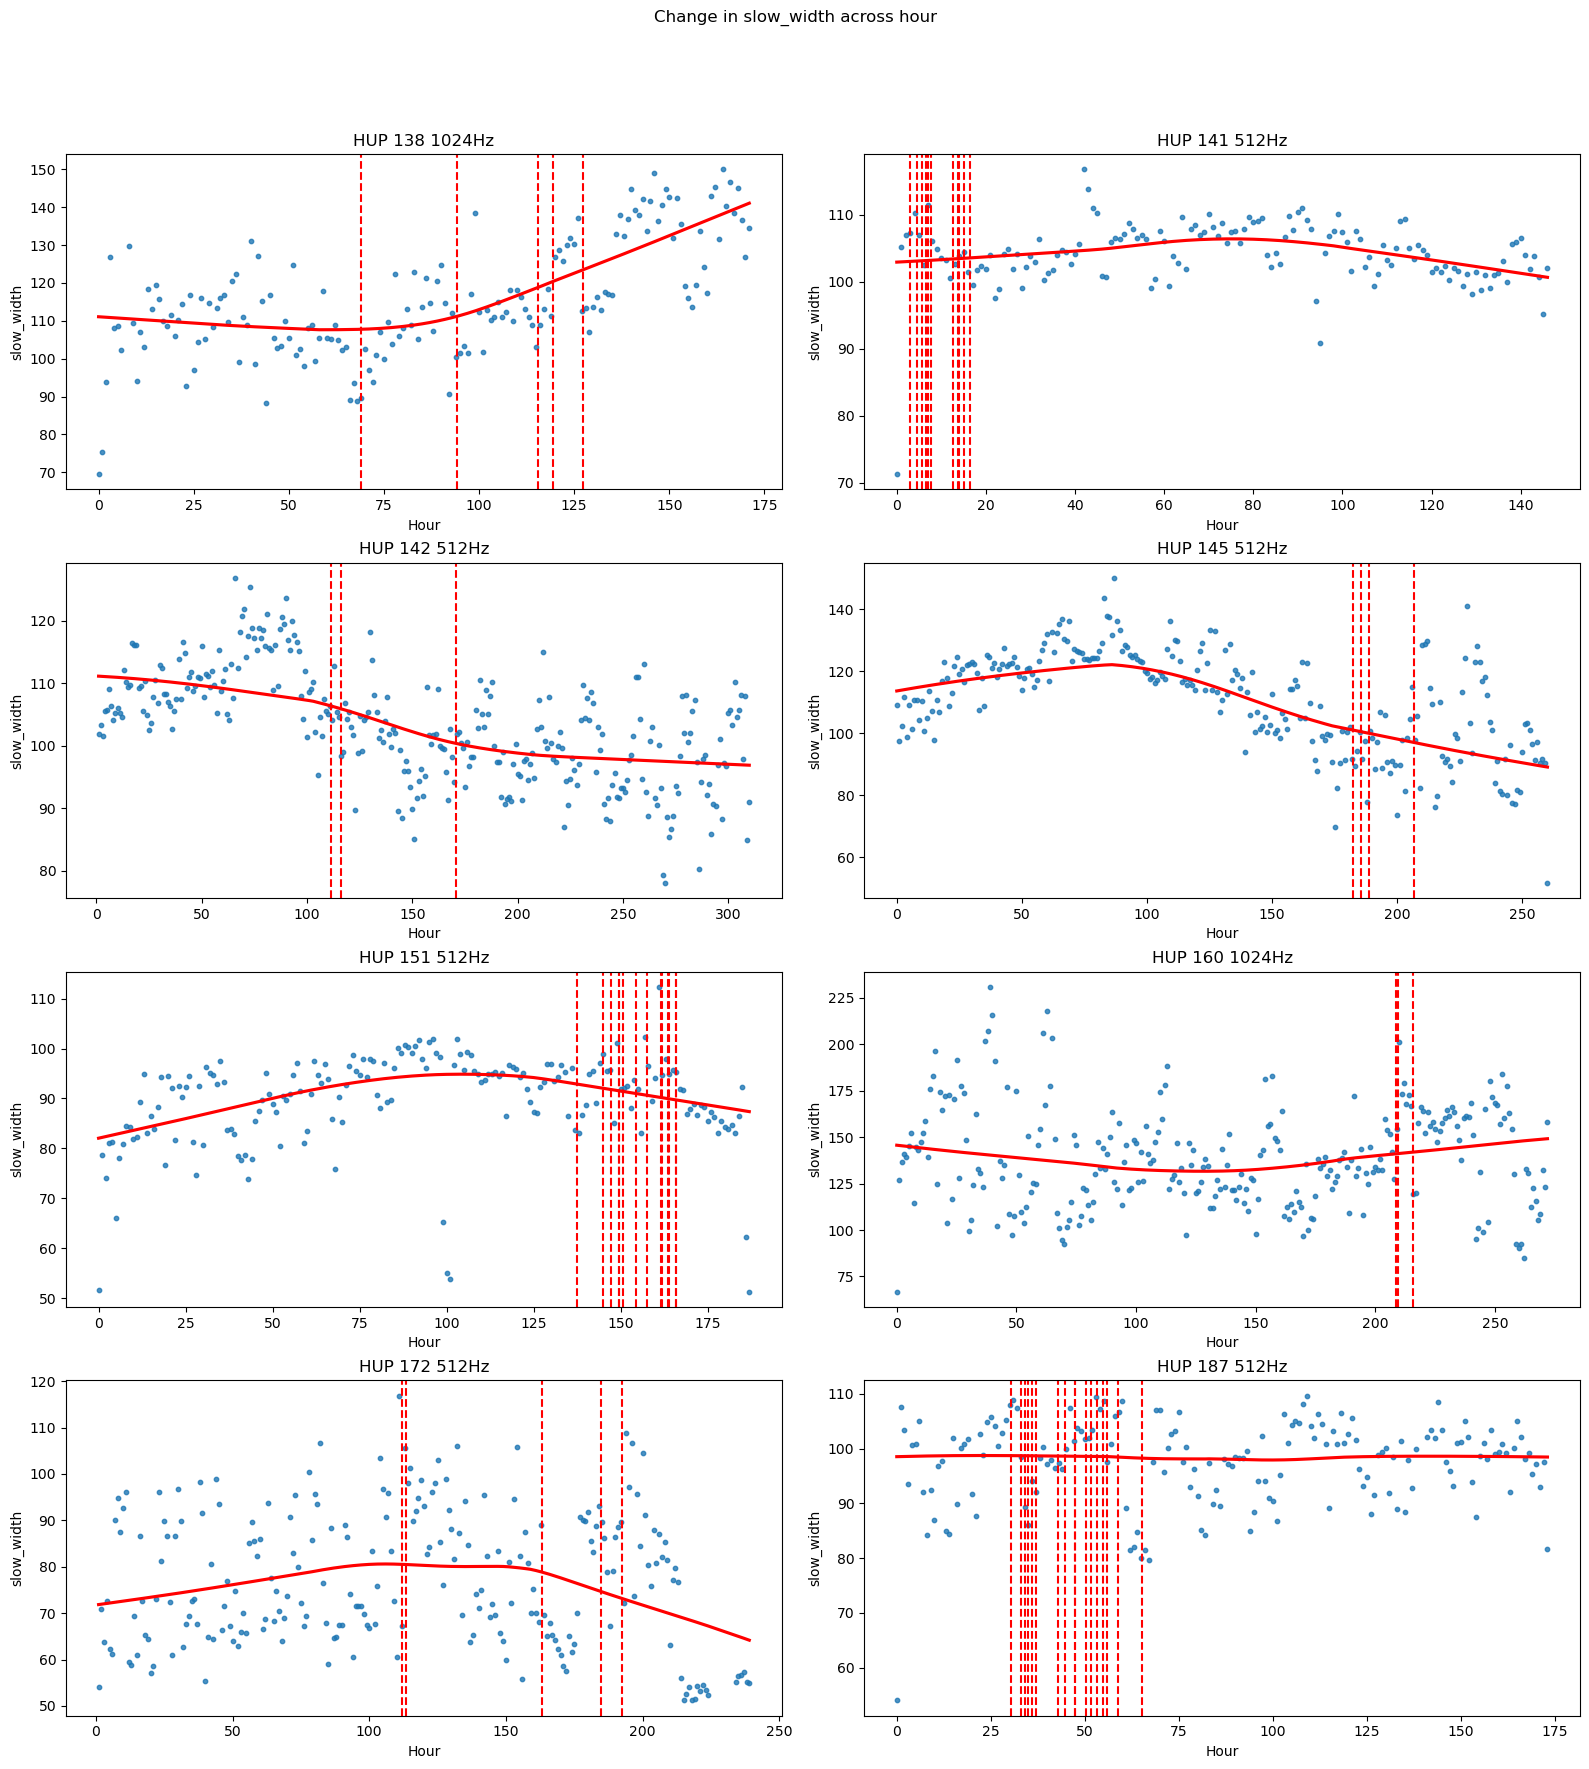

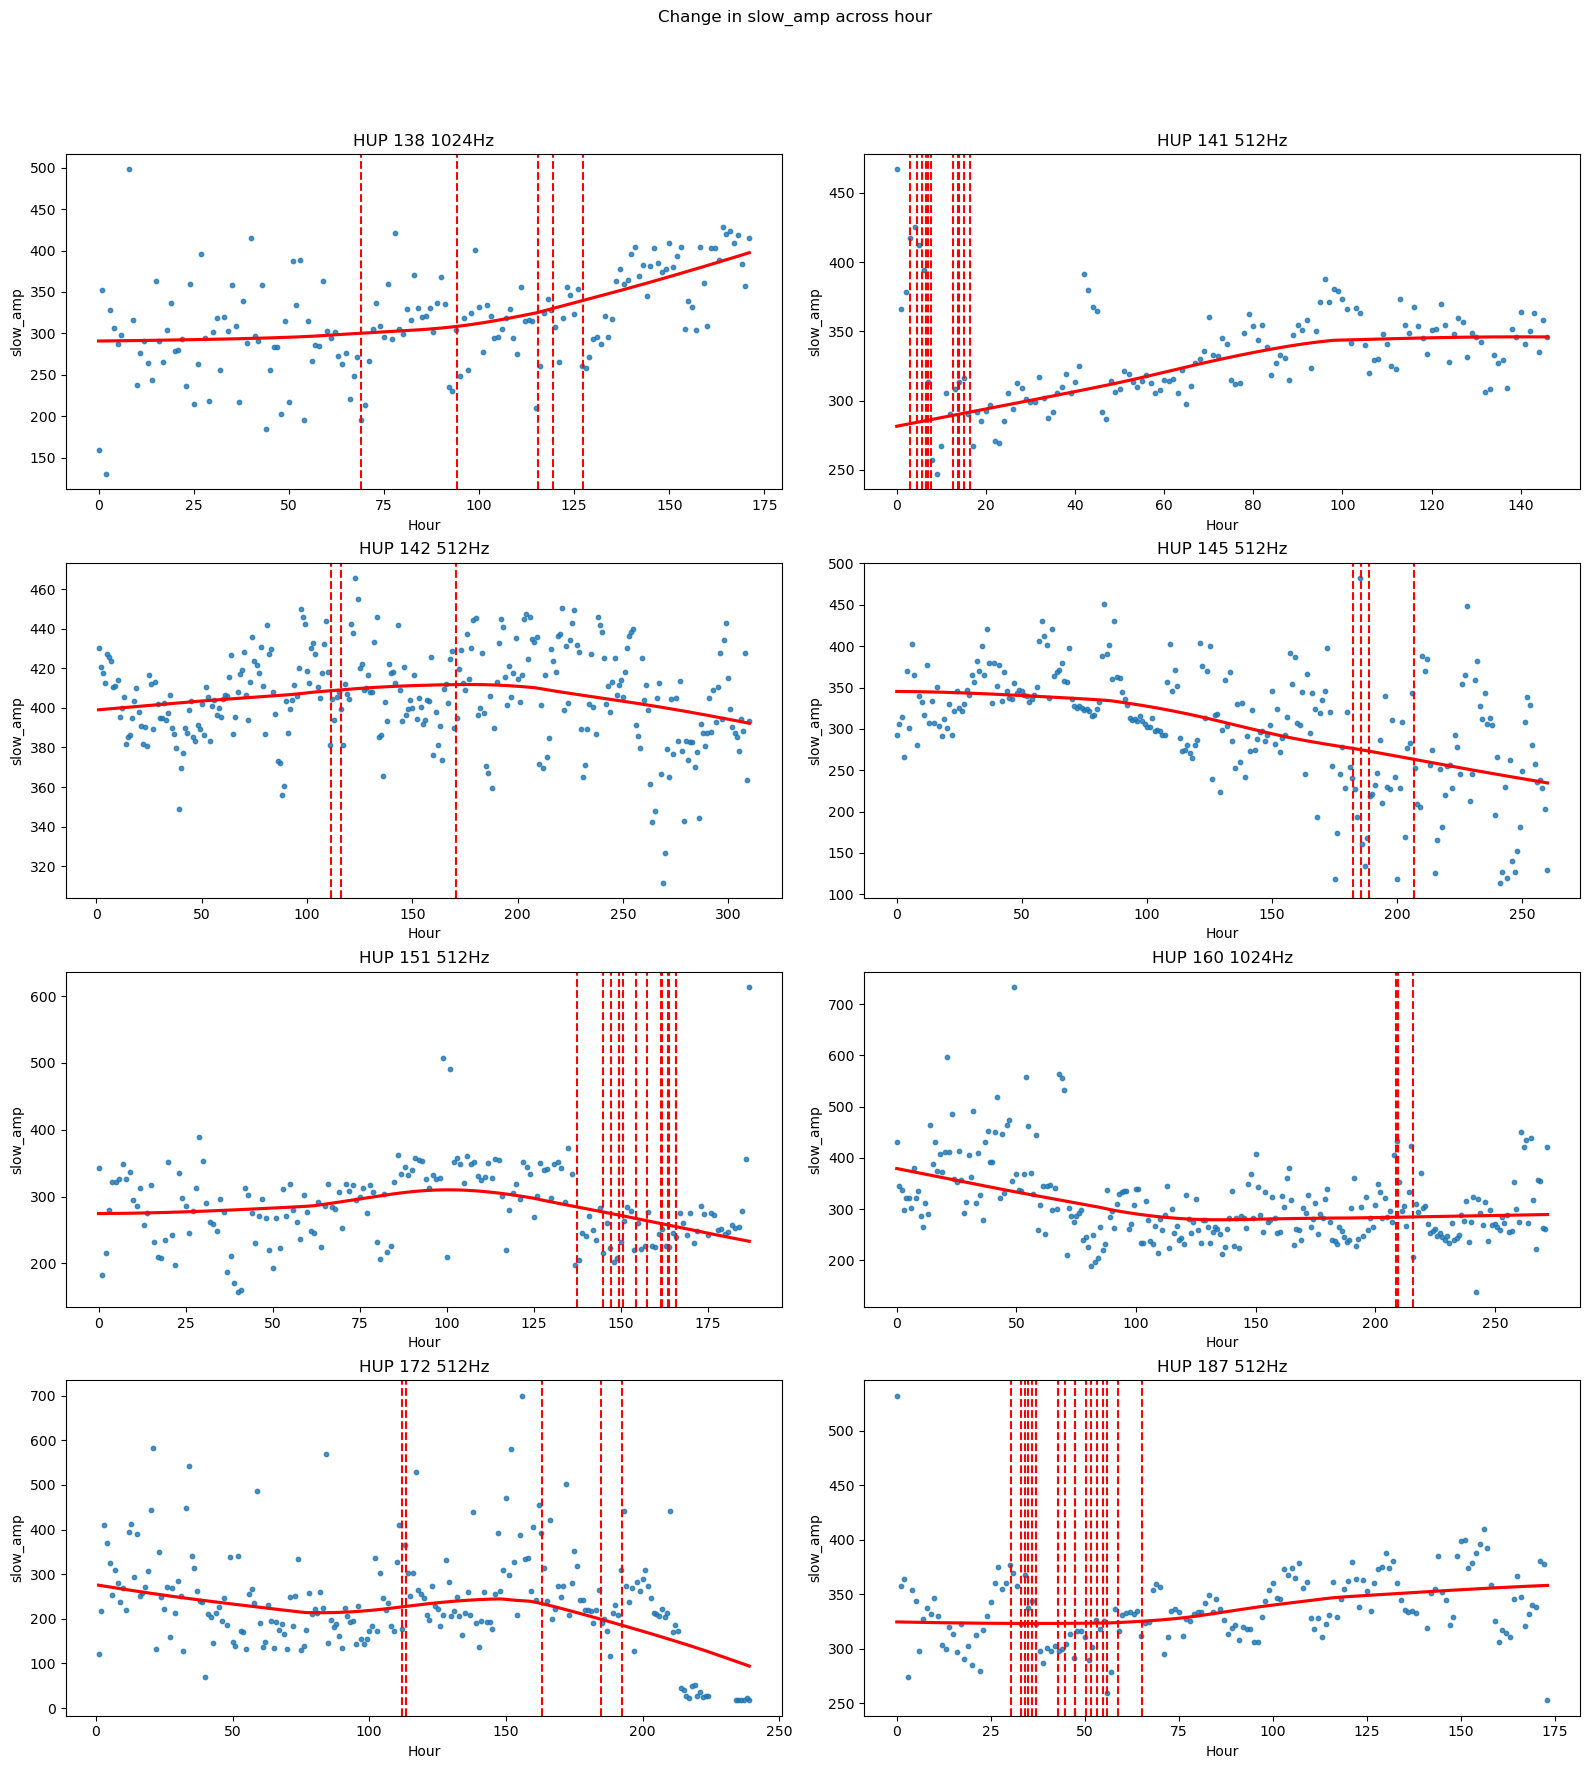

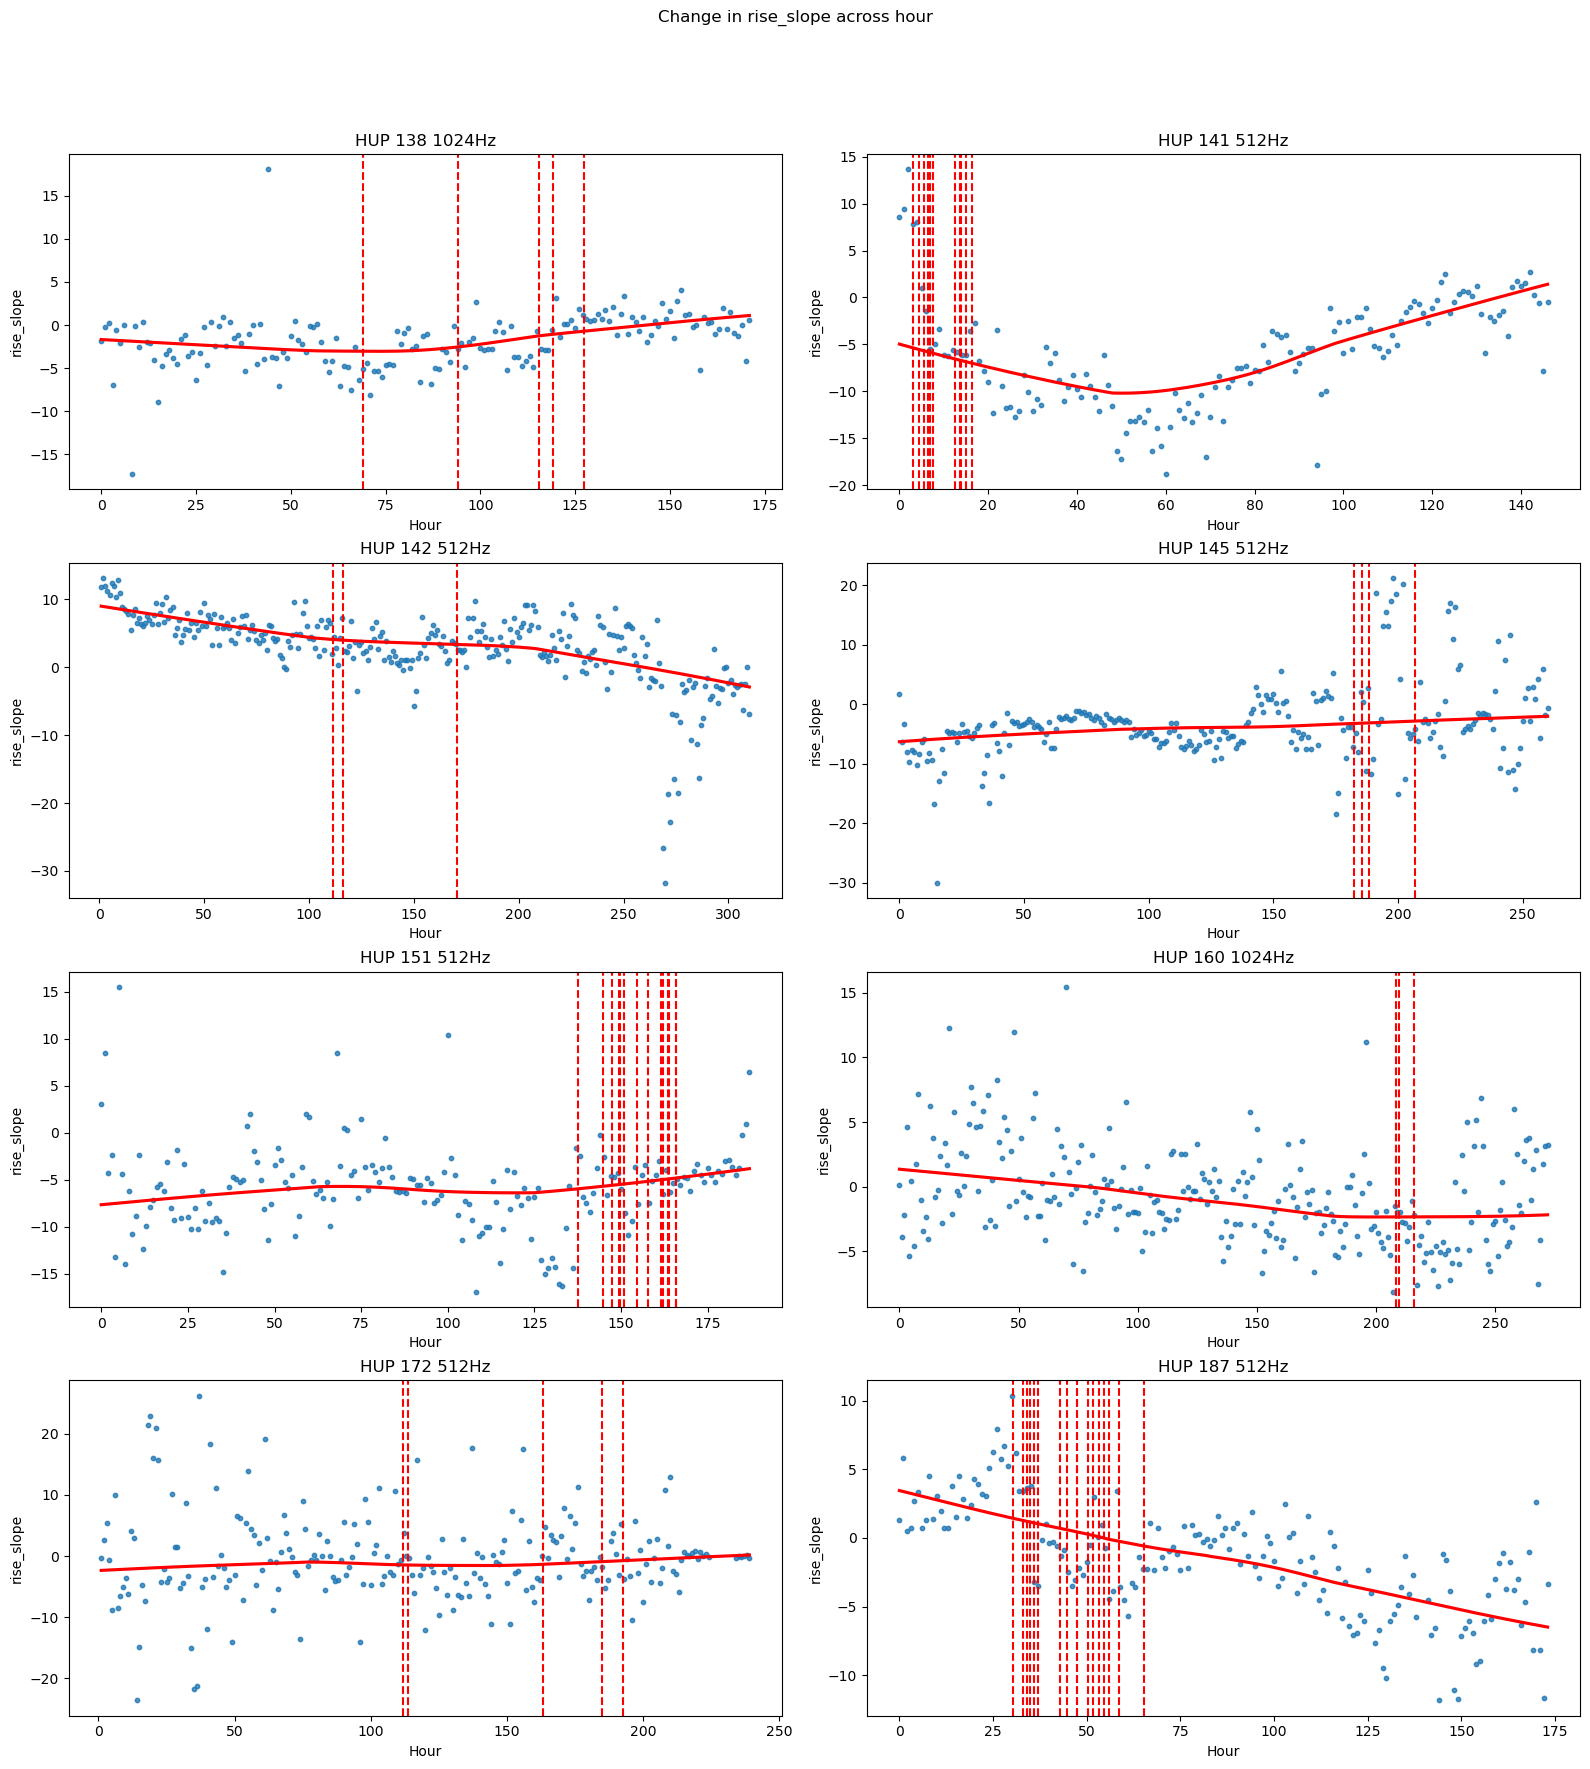

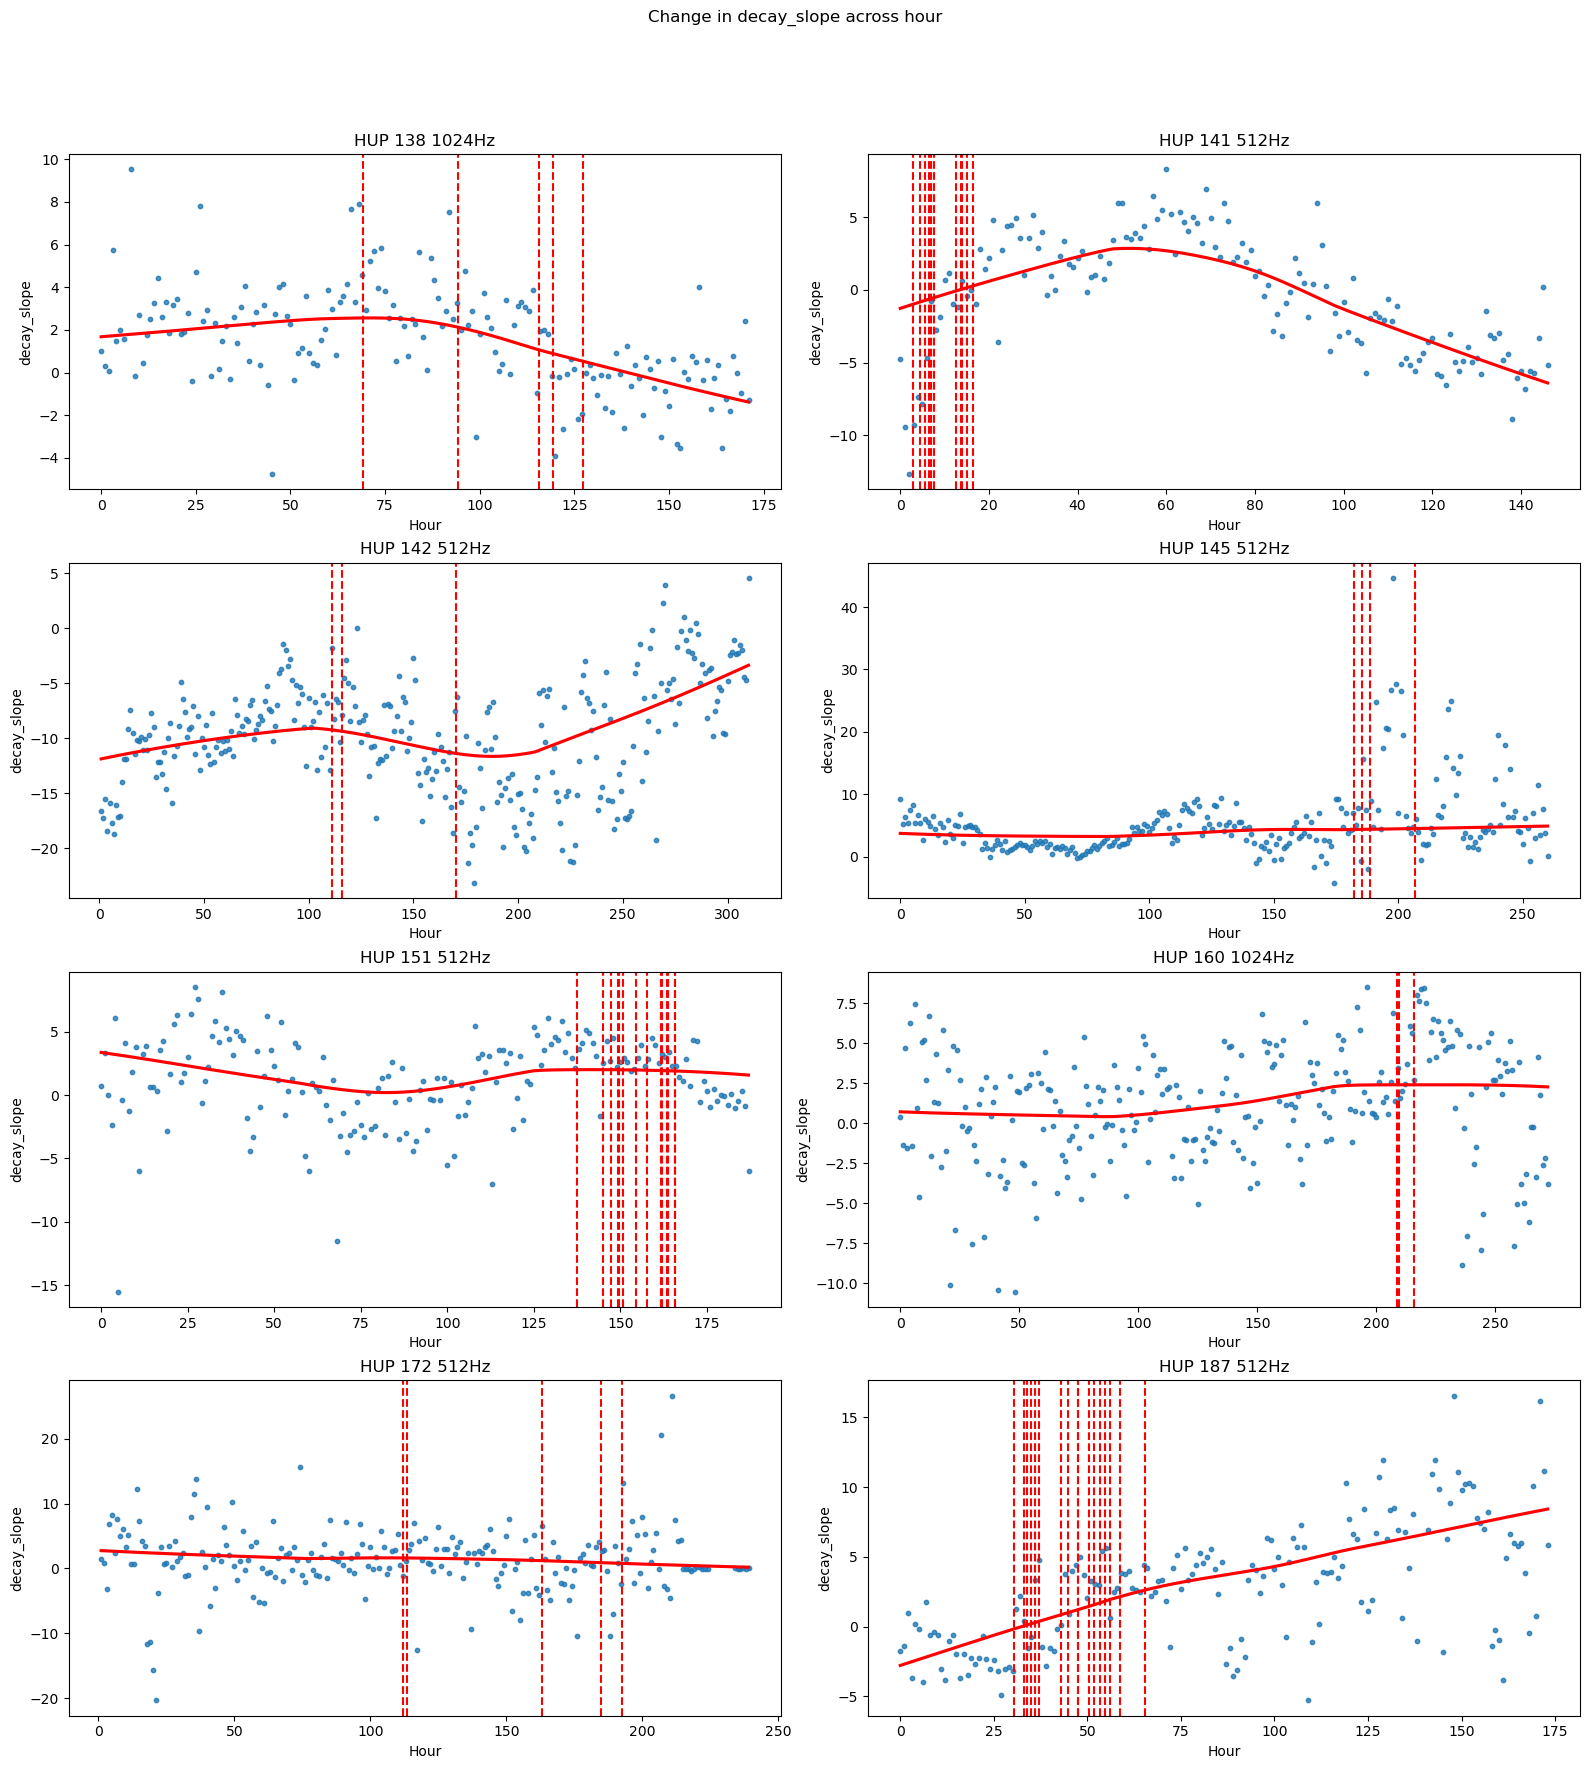

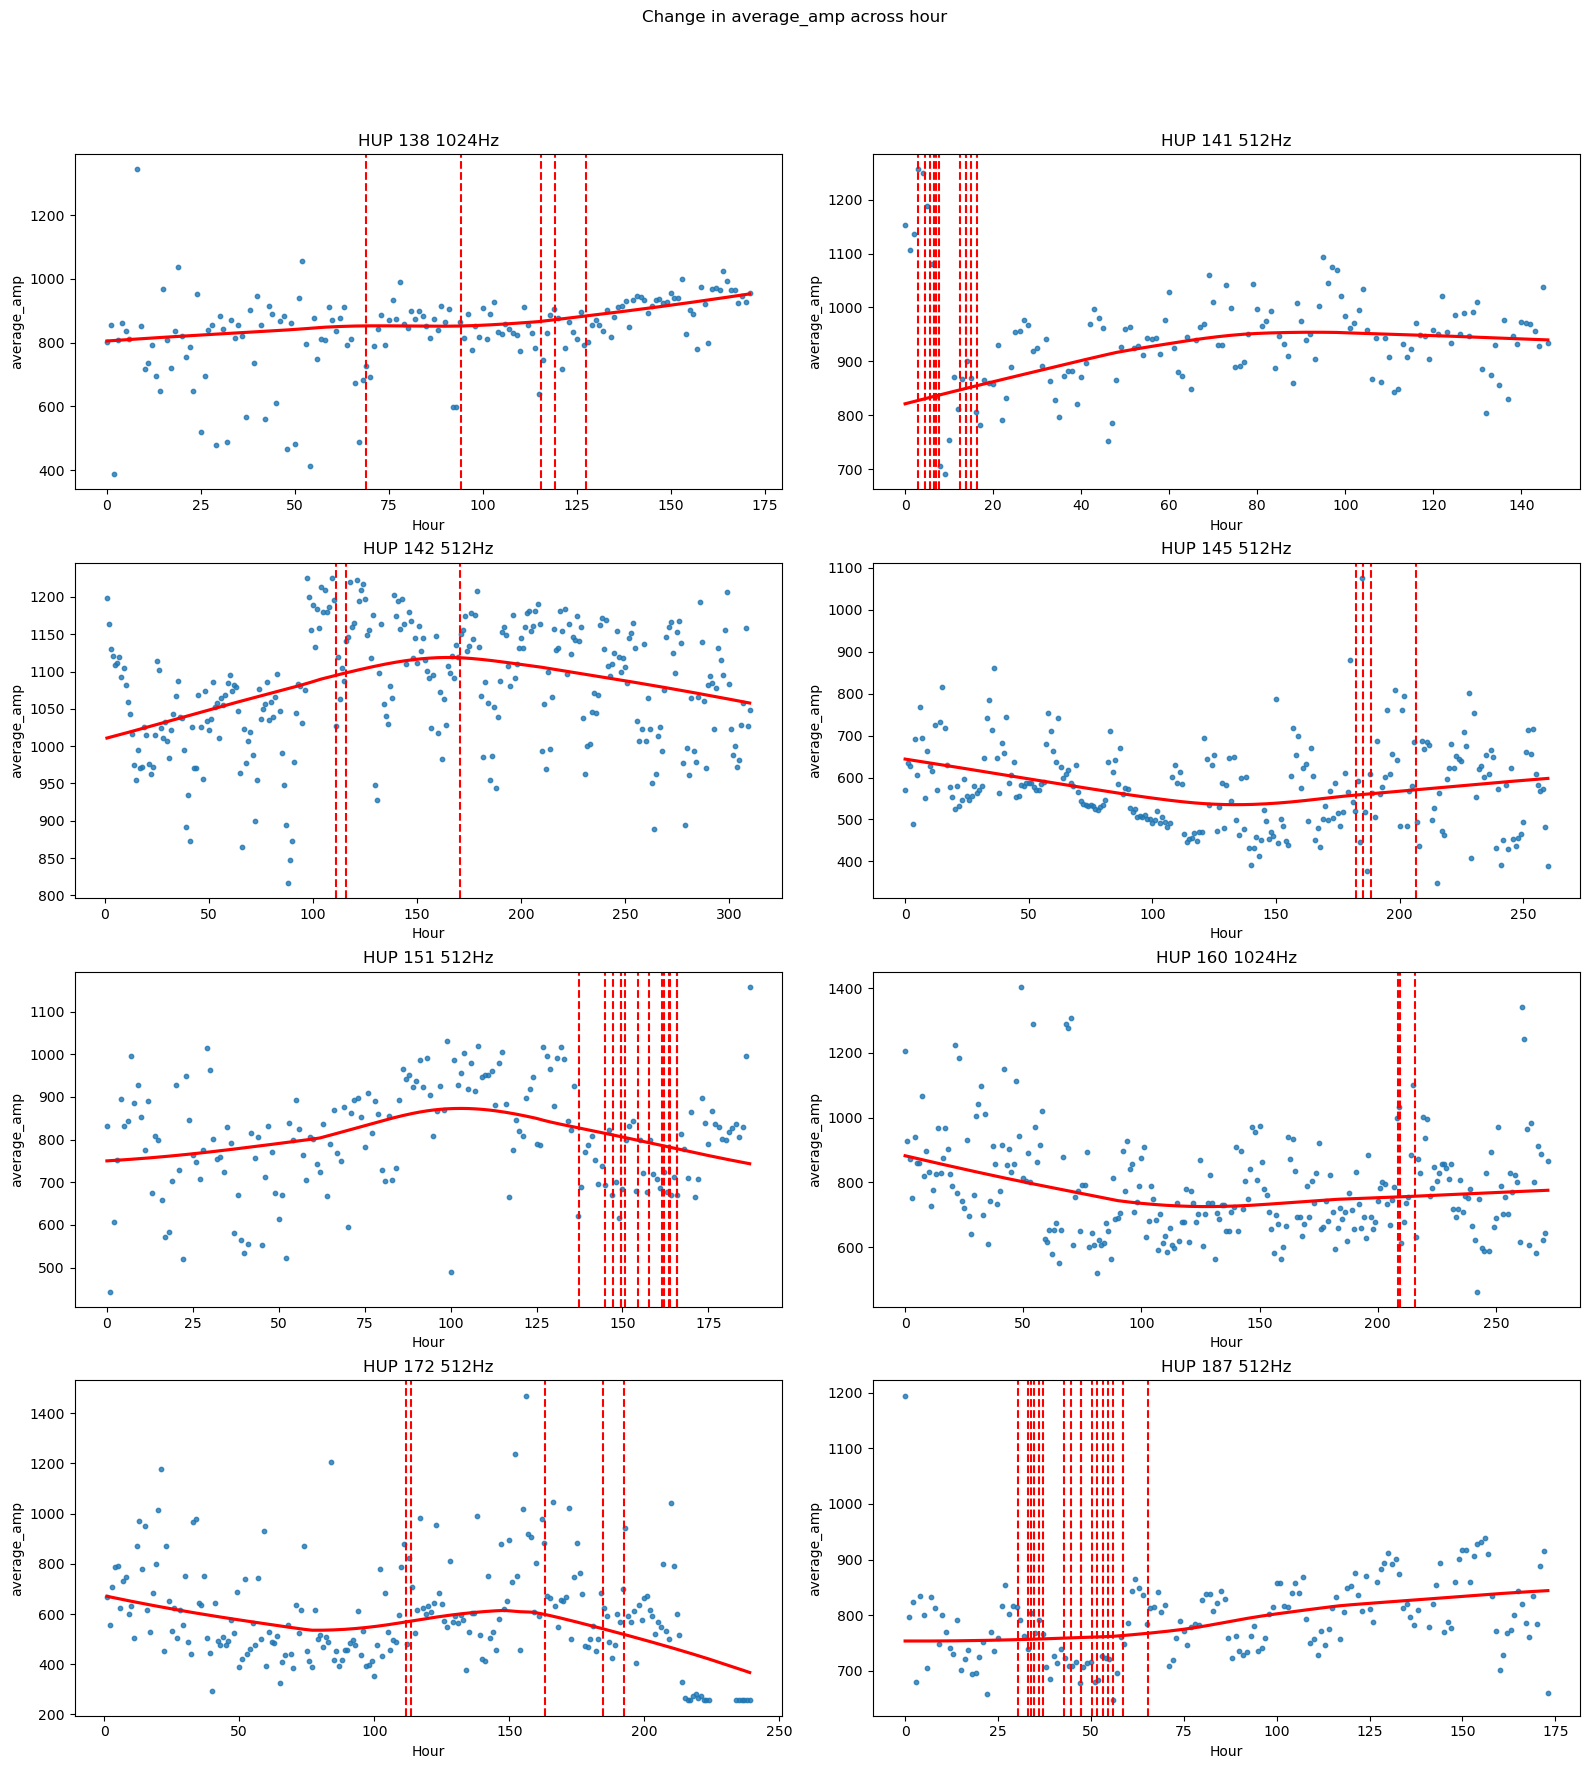

In [15]:
features = [
    "slow_max",
    "rise_amp",
    "decay_amp",
    "slow_width",
    "slow_amp",
    "rise_slope",
    "decay_slope",
    "average_amp",
]

for feature in features:
    fig, axarr = plt.subplots(
        nrows=(len(all_spikes_dfs) + 1) // 2,
        ncols=2,
        figsize=(16, 4 * (len(all_spikes_dfs) + 1) // 2),
    )
    fig.suptitle(f"Change in {feature} across hour")

    for idx, (df, hup_id, fs) in enumerate(
        zip(all_spikes_dfs, completed_hup_ids, all_fs)
    ):
        grouped = df.groupby("peak_hour").mean()
        row = idx // 2
        col = idx % 2
        sns.regplot(
            x=grouped.index,
            y=grouped[feature],
            ax=axarr[row, col],
            lowess=True,
            scatter_kws={"s": 10},
            line_kws={"color": "red"},
        )
        axarr[row, col].set_title(f"HUP {hup_id} {fs}Hz")
        axarr[row, col].set_xlabel("Hour")
        axarr[row, col].set_ylabel(feature)

        # Load seizure times and plot vertical lines
        seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
        seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours
        for seizure_time in seizure_times_hour:
            axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    # Delete unused subplots
    for i in range(len(all_spikes_dfs), 2 * ((len(all_spikes_dfs) + 1) // 2)):
        row = i // 2
        col = i % 2
        fig.delaxes(axarr[row, col])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()